
## Prices Guide

<hr style='margin-bottom:20px; margin-top:25px'>

<p>This code executes a script that recolects and cleanses data recolected from publications from the top selling portals on Mexico and the mainstream official guide prices over every car brand,
and calculates a price that has real accuracy based on the offer and demand over that vehicle</p>

<p>It proceses the data to correct any
outlier and any gap in between prices, eliminates fake publications that can alter the data, generates different sets of information, by partitioning the data on every source that was occupied in the process and makes various agruppations based on selling time and geographic information to give a real depth inside about the behaviour of that particular vehicle and its expected price over the next three months.</p>

<p>The average selling time, and the price in every state of the country where the data was recolected is calculated and added in a JSON format.</p>

<p>—› Various AI preddicting models where used in this project, the script is trained to addapt and use the most suitable model according to the data.</p>

<p>—› The script handles a database of over 40k entrances, to optimice time, it ocuppies a multiprosesing package that generates 16 subproceses, multiplying the speed 16X times, with every process being alocated in every core of the CPU</p>

<p>—› A AWS cloud integration was necessary to run the script with 16 cores, EC2 prooved to be the best reliable option based on price/beneffit</p>

<p>—› This notebook is provided with some text cells wich explains in a visual way what is happening on the code.</p>

<p>—› This is a very extense project so i'll only give some examples as how some functions are thought an executed</p>

<hr style='margin-bottom:20px; margin-top:25px'>





In [ ]:
print('IMPORTES')
from comparativaHermanos import get_hermanos
from HoleImputerFunction_version_maxi import *
import forecast as forecastTool
import actualización_de_precios
import multiprocessing as mp
import datetime
import numpy
import pymongo
from datetime import datetime as dt
import os
import statistics
import numpy as np
import pandas as pd
import math
import traceback
print('FINALIZADOS')
from IPython.display import Image
Image(filename='output1.png',width=800, height=400)

In [ ]:


def create_price_a(cats, EBC, GAM, MERCADO_LIBRE, SAM, SITIOS, MAXI, NUEVOS, OCATMXMXP, flags):
    for cat in cats:
        for flag in flags:
            try:
                ebc, gam, mercadoLibre, sam, sitios, maxi, precio_nuevos, oCatMxMxp = EBC, GAM, MERCADO_LIBRE, SAM, SITIOS, MAXI, NUEVOS, OCATMXMXP
                # fig, ax = plt.subplots(figsize=(18, 8), dpi=120)
                # Código de generación de precios, en caso de haber error, omitir y anotar
                """
                Definición de variables de entrada
                """
                # print(str(psutil.cpu_percent()))
                # print('\r', str(psutil.cpu_percent()), end='')
                construct_dataframe_predict = forecastTool.construct_dataframe_predict
                isForecast, newLimit, rebazaNuevos, mlmData, sam_data, samSwitch, sin_anuncios, ebcNewData = False, False, False, False, False, False, False, False
                categGam, nuevosX, nuevosY, ebc_nuevos_comparative, weightENTERPRISE, \
                    allWeight, allWeightY, allWeightX, weightPerDateMaxi, weightPerDateSites, datesENTERPRISE, xMlm, yMlm = None, None, None, None, None, None, None, None, None, None, None, None, None
                forecast, upper, lower, upperEbc, lowerEbc, upperGam, lowerGam = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
                sam_info, originalWeightAnuncios, originalWeightMaxi, weightMaxi, weightAnuncios = 0, 0, 0, 0, 0
                brand, model, year, trim, extId = '', '', '', '', ''
                samNuevosX, samNuevosY, categMxp = None, None, None
                mlmId, samId = None, None
                x_ebc_forecast, y_ebc_forecast = None, None
                x_gam_forecast, y_gam_forecast = None, None
                quantiles_agruppation = pd.DataFrame(data=[], index=[])
                upperY, lowerY = 0, 0
                samWeight, smmWeight, mlmWeight = 0, 0, 0
                cat = cat
                category = cat
                dataframe_stateId_maxi = pd.DataFrame()
                dataframe_stateId_anuncios_aux = pd.DataFrame()
                state_prices = {}
                economic_zone_prices = {}
                """
                Recolección de las categorías Homologadas en fuentes de EBC y ATM
                """

                parentId = ''
                parents = cat.split('_')[0:5]
                count = 0
                for i in parents:
                    if count != 4:
                        parentId = parentId + i + '_'
                        count += 1
                    else:
                        parentId = parentId + i

                oCatMxMxpInfo = oCatMxMxp.loc[oCatMxMxp['categoryId'] == cat]
                if oCatMxMxpInfo['gam'].values.all() != None:
                    categGam = oCatMxMxpInfo['gam'].values[0]
                    # categGam = oCatMxMxp.loc[oCatMxMxp['categoryId'] == cat]['gam'].values[0]

                if oCatMxMxpInfo['ebc'].values.all() != None:
                    categMxp = oCatMxMxpInfo['ebc'].values[0]
                    # categMxp = oCatMxMxp.loc[oCatMxMxp['categoryId'] == cat]['ebc'].values[0]

                if oCatMxMxpInfo['mlm'].values.all() != None:
                    mlmId = oCatMxMxpInfo['mlm'].values[0]

                if oCatMxMxpInfo['sam'].values.all() != None:
                    samId = oCatMxMxpInfo['sam'].values[0]

                if type(mlmId) == str:
                    mercadoLibre = mercadoLibre[mercadoLibre['productId'] == mlmId]
                    mercadoLibre = mercadoLibre.loc[mercadoLibre['price'] > 100]
                    if mercadoLibre.empty == False:
                        mlmData = True
                    else:
                        mercadoLibre = np.nan
                else:
                    mercadoLibre = np.nan

                if samId:
                    sam_info = sam[sam['categoryId'] == samId]
                    sam_info = sam_info.drop_duplicates(subset='dateCreated', keep="first")
                    if sam_info.empty != True:
                        sam_data = True

                if type(categMxp) == str:
                    ebc = ebc.loc[ebc['categoryId'] == categMxp]
                else:
                    ebc = pd.DataFrame(data=[], index=[])
                if type(categGam) == str:
                    gam = gam.loc[gam['categoryId'] == categGam]
                    gam = gam.loc[gam.price > 1]
                    # gam.dropna(inplace=True)

                else:
                    gam = pd.DataFrame(data=[], index=[])

                ads = maxi.loc[maxi['categoryId'] == cat]
                sites = sitios.loc[sitios['categoryId'] == cat]

                sites_no_homologated = sitios.loc[sitios['categoryId'] == parentId]

                # Concatenación de anuncios a nivel versión y a nivel año
                sites = pd.concat([sites, sites_no_homologated])

                sites = sites[sites['lastUpdated'].notna()]
                ads = ads[ads['lastUpdated'].notna()]

                if flag != 'all':
                    sites = sites.loc[sites['type'] == flag]
                if flag == 'private_seller':
                    ads = pd.DataFrame(data=[], index=[])

                if len(ads.index.values) == 1:
                    ads = pd.DataFrame(data=[], index=[])
                    ads = pd.DataFrame(data=[], index=[])
                brand = oCatMxMxpInfo['brand'].values[0]
                model = oCatMxMxpInfo['model'].values[0]
                year = oCatMxMxpInfo['year'].values[0]
                trim = oCatMxMxpInfo['trim'].values[0]

                if brand == None:
                    brand = ebc['brand'].values[0]
                    model = ebc['model'].values[0]
                    year = ebc['year'].values[0]
                    trim = ebc['trim'].values[0]
                if brand == None:
                    brand = ebc['brand'].values[0]
                    model = ebc['model'].values[0]
                    year = ebc['year'].values[0]
                    trim = ebc['trim'].values[0]

                externalState = {}
                country = {}
                MPstate = {}
                MPcountry = {'MX': 0}

                tpv = pd.DataFrame(data=[], index=[])
                tpvX = None
                tpvY = None
                salesX = None
                salesY = None

                adsTpvY = np.nan
                adsTpvX = np.nan

                sitesTpvY = np.nan
                sitesTpvX = np.nan

                salesSites = pd.DataFrame(data=[], index=[])
                salesMaxi = pd.DataFrame(data=[], index=[])

                # recolección de tiempos y ventas de anuncios maxi
                if sites.empty == False:
                    # sitesTpv = sites
                    sitesTpv = sites.loc[sites['siteId'] == 'MLM']
                    sitesTpv = sitesTpv.loc[sitesTpv['status'] == 'closed']

                    # sitesTpv['salesSites'] = range(0, len(sitesTpv.index.values))

                    if sitesTpv.empty == False and 'tpv' in list(sitesTpv.columns):
                        sitesTpv['lastUpdated'] = pd.to_datetime(sitesTpv['lastUpdated'],
                                                                 infer_datetime_format=True).dt.strftime('%Y-%m-01')

                        sitesTpv['lastUpdated'] = pd.to_datetime(sitesTpv['lastUpdated'],
                                                                 infer_datetime_format=True)
                        sitesTpv.dropna(inplace=True, axis=0)

                        salesSites = pd.DataFrame(data=[1] * len(sitesTpv.lastUpdated.values),
                                                  index=sitesTpv.lastUpdated.values)
                        sitesTpv = sitesTpv['tpv'].groupby(sitesTpv['lastUpdated']).mean()
                        sitesTpvX = [str(date).strip(' 00:00:00') for date in np.reshape(sitesTpv.index, (-1))]
                        sitesTpvY = [int(precio) for precio in np.reshape(sitesTpv.values, (-1))]

                        tpv = pd.concat([tpv, sitesTpv])

                    else:

                        sitesTpvY = np.nan
                        sitesTpvX = np.nan

                # recolección de tiempos y ventas de anuncios maxi
                if ads.empty == False:
                    # sitesTpv = sites
                    # adsTpv = sites.loc[sites['siteId'] == 'MLM']
                    maxiTpv = ads.loc[ads['status'] == 'closed']
                    if maxiTpv.empty == False and 'tpv' in list(maxiTpv.columns):
                        maxiTpv['lastUpdated'] = pd.to_datetime(maxiTpv['lastUpdated'],
                                                                infer_datetime_format=True).dt.strftime('%Y-%m-01')

                        maxiTpv['lastUpdated'] = pd.to_datetime(maxiTpv['lastUpdated'],
                                                                infer_datetime_format=True)
                        maxiTpv.dropna(inplace=True, axis=0)
                        salesMaxi = pd.DataFrame(data=[1] * len(maxiTpv.lastUpdated.values),
                                                 index=maxiTpv.lastUpdated.values)
                        maxiTpv = maxiTpv['tpv'].groupby(maxiTpv['lastUpdated']).mean()
                        adsTpvX = [str(date).strip(' 00:00:00') for date in np.reshape(maxiTpv.index, (-1))]
                        adsTpvY = [int(precio) for precio in np.reshape(maxiTpv.values, (-1))]

                        tpv = pd.concat([tpv, maxiTpv])

                    else:
                        adsTpvY = np.nan
                        adsTpvX = np.nan

                sales = pd.concat([salesSites, salesMaxi])
                # agrupación de las ventas por mes
                if sales.empty == False:
                    sales.columns = ['sales']
                    sales['lastUpdated'] = sales.index.values

                    sales = sales['sales'].groupby(sales['lastUpdated']).sum()
                    range_fechas = pd.date_range(start=sales.index.values[0], end=sales.index.values[-1],
                                                 freq='MS')
                    sales = sales.reindex(range_fechas, fill_value=np.nan)
                    sales = sales.rolling(4, min_periods=1, center=False, closed='both').mean()
                    sales = sales.rolling(2, min_periods=1, center=False, closed='both').mean()

                    sales.fillna(0, inplace=True)

                    # print(sales.to_string())
                    salesX = [str(date).strip(' 00:00:00') for date in np.reshape(sales.index, (-1))]
                    salesY = [int(precio) for precio in np.reshape(sales.values, (-1))]

                # agrupación de lps tiempos de venta
                if tpv.empty == False:
                    tpv = pd.DataFrame(data=tpv.values, index=tpv.index, columns=['tpv'])
                    tpv['lastUpdated'] = tpv.index.values
                    tpv.index = pd.to_datetime(tpv.index, infer_datetime_format=True)
                    tpv = tpv['tpv'].groupby(tpv['lastUpdated']).mean()
                    range_fechas = pd.date_range(start=tpv.index.values[0], end=tpv.index.values[-1],
                                                 freq='MS')
                    tpv = tpv.reindex(range_fechas, fill_value=np.nan)
                    tpv = tpv.rolling(4, min_periods=1, center=False, closed='both').mean()
                    tpv = tpv.rolling(2, min_periods=1, center=False, closed='both').mean()

                    tpv.fillna(0, inplace=True)

                    tpvX = [str(date).strip(' 00:00:00') for date in np.reshape(tpv.index, (-1))]
                    tpvY = [int(precio) for precio in np.reshape(tpv.values, (-1))]
                    tpv = sum(tpv.values) / len(tpv.values)

                else:
                    tpv = 0

                if len(ads.index.values) == 1 and ads.price.values[0] > 1000000:
                    ads = pd.DataFrame(data=[], index=[])
                if len(sites.index.values) == 1 and sites.price.values[0] > 1000000:
                    sites = pd.DataFrame(data=[], index=[])

                limit = False
                df = pd.DataFrame(data=[], index=[])
                # recolección de precios de EBC
                if categMxp:
                    try:
                        df = precio_nuevos.loc[precio_nuevos['categoryId'] == categMxp]
                        # df.drop(columns="_id", inplace=True)
                        df.dropna(inplace=True, axis=0)
                        df = df[df['price'].notna()]
                        df.index.name = None
                        df.sort_values(by='dateCreated', axis=0, inplace=True)
                        df.index = df.dateCreated
                        df.index = pd.to_datetime(df['dateCreated'], infer_datetime_format=True)
                        range_new = pd.date_range(start=df.index.values[0], end=df.index.values[-1], freq='MS')
                        df.drop(labels=['dateCreated'], axis=1, inplace=True)
                        df = df.reindex(range_new, fill_value=np.nan)
                        df['dateCreated'] = df.index

                        precios = [int(i) for i in df.price.values if str(i) != 'nan']
                        for i in precios:
                            statistics.mean(precios)
                            if i < statistics.mean(precios) * 0.85:
                                error = df.loc[df.price == i]
                                index = error.index.values[0]
                                df.at[index, 'price'] = np.nan

                        df = update_forecast_from_dataframe_one_column(df, 'price', 'dateCreated')
                        df.index = df.dateCreated
                        df.dropna(axis=0, inplace=True)
                        limit = True
                        ebcNewData = True
                    except:
                        pass

                if limit == False and sam_data:
                    samSwitch = True
                    df = sam_info
                    limit = True

                elif limit and len(df.price.values) == 1 and sam_data:
                    samSwitch = True
                    df = sam_info
                    limit = True

                frames = []
                emulation_frames = []

                # eliminación de anomalías y precios fuera de rango (externos)
                if sites.empty == False and sites.price.values.all() != None:
                    anuncios = sites
                    anuncios['lastProcessed'] = pd.to_datetime(anuncios['lastProcessed'],
                                                               infer_datetime_format=True).dt.strftime('%Y-%m-01')
                    anuncios['lastProcessed'] = pd.to_datetime(anuncios['lastProcessed'])
                    anunciosFiltrados = pd.DataFrame(data=[], index=[])
                    anuncios = anuncios.sort_values('lastProcessed')

                    if limit and anuncios.empty == False:
                        news_range = pd.date_range(start=df.index.values[0], end=df.index.values[-1], freq='MS')
                        anunciosRange = pd.date_range(start=anuncios.lastProcessed.values[0],
                                                      end=anuncios.lastProcessed.values[-1], freq='MS')
                        backward_range = pd.date_range(start=df.index.values[0], end=anuncios.lastProcessed.values[-1],
                                                       freq='MS')
                        forward_range = pd.date_range(start=anuncios.lastProcessed.values[0], end=df.index.values[-1],
                                                      freq='MS')
                        comparativaAnuncios = df
                        comparativaAnuncios['lastProcessed'] = pd.to_datetime(comparativaAnuncios.dateCreated)

                        llegaMasLejos = news_range.tolist()[-1] >= anunciosRange.tolist()[-1]
                        llegaMasAtras = news_range.tolist()[0] <= anunciosRange.tolist()[0]

                        if not llegaMasAtras and not llegaMasLejos:
                            extendedBackward = comparativaAnuncios.price.values[0]
                            extendedForward = comparativaAnuncios.price.values[-1]
                            comparativaAnuncios = comparativaAnuncios.reindex(anunciosRange, fill_value=np.nan)
                            comparativaAnuncios['lastProcessed'] = comparativaAnuncios.index
                            comparativaAnuncios.reset_index(drop=True, inplace=True)
                            comparativaAnuncios.at[comparativaAnuncios.index.values[0], 'price'] = extendedBackward
                            comparativaAnuncios.at[comparativaAnuncios.index.values[-1], 'price'] = extendedForward
                            comparativaAnuncios = update_forecast_from_dataframe_one_column(comparativaAnuncios,
                                                                                            'price',
                                                                                            'lastProcessed')

                        elif llegaMasAtras and not llegaMasLejos:
                            extendedForward = comparativaAnuncios.price.values[-1]
                            comparativaAnuncios['lastProcessed'] = comparativaAnuncios.index
                            comparativaAnuncios.reset_index(drop=True, inplace=True)
                            insertion = pd.DataFrame({'price': [extendedForward],
                                                      'lastProcessed': [backward_range[-1]]})
                            comparativaAnuncios = pd.concat([comparativaAnuncios, insertion])
                            comparativaAnuncios.index.name = None
                            comparativaAnuncios.sort_values(by='lastProcessed', axis=0, inplace=True)
                            comparativaAnuncios.index = comparativaAnuncios['lastProcessed']

                            comparativaAnuncios.drop_duplicates(inplace=True)
                            comparativaAnuncios = comparativaAnuncios['price'].groupby(
                                comparativaAnuncios.lastProcessed).mean()
                            comparativaAnuncios = pd.DataFrame(data=comparativaAnuncios.values,
                                                               index=comparativaAnuncios.index.values,
                                                               columns=['price'])

                            comparativaAnuncios = comparativaAnuncios.reindex(backward_range, fill_value=np.nan)
                            comparativaAnuncios['lastProcessed'] = comparativaAnuncios.index
                            comparativaAnuncios.reset_index(drop=True, inplace=True)
                            comparativaAnuncios.at[comparativaAnuncios.index.values[-1], 'price'] = extendedForward
                            comparativaAnuncios = update_forecast_from_dataframe_one_column(comparativaAnuncios,
                                                                                            'price',
                                                                                            'lastProcessed')

                        elif llegaMasLejos and not llegaMasAtras:
                            extendedBackward = comparativaAnuncios.price.values[0]
                            comparativaAnuncios['lastProcessed'] = comparativaAnuncios.index
                            comparativaAnuncios.reset_index(drop=True, inplace=True)
                            insertion = pd.DataFrame({'price': [extendedBackward],
                                                      'lastProcessed': [forward_range[-1]]})
                            comparativaAnuncios = pd.concat([comparativaAnuncios, insertion])
                            comparativaAnuncios.index.name = None
                            comparativaAnuncios.sort_values(by='lastProcessed', axis=0, inplace=True)
                            comparativaAnuncios.index = comparativaAnuncios['lastProcessed']

                            comparativaAnuncios.drop_duplicates(inplace=True)
                            comparativaAnuncios = comparativaAnuncios['price'].groupby(
                                comparativaAnuncios.lastProcessed).mean()
                            comparativaAnuncios = pd.DataFrame(data=comparativaAnuncios.values,
                                                               index=comparativaAnuncios.index.values,
                                                               columns=['price'])

                            comparativaAnuncios = comparativaAnuncios.reindex(forward_range, fill_value=np.nan)
                            comparativaAnuncios['lastProcessed'] = comparativaAnuncios.index
                            comparativaAnuncios.reset_index(drop=True, inplace=True)
                            comparativaAnuncios.at[comparativaAnuncios.index.values[0], 'price'] = extendedBackward
                            comparativaAnuncios = update_forecast_from_dataframe_one_column(comparativaAnuncios,
                                                                                            'price',
                                                                                            'lastProcessed')
                            
                        for date in anuncios.lastProcessed.drop_duplicates():
                            precios = anuncios.loc[anuncios.lastProcessed == date]
                            limite = comparativaAnuncios.loc[comparativaAnuncios.lastProcessed == date].price.values[0]
                            precios = precios.loc[precios.price < limite]
                            anunciosFiltrados = pd.concat([anunciosFiltrados, precios])

                    if limit:
                        df.index = df.lastProcessed
                        anuncios = anunciosFiltrados
                    
                    

<p>At this line of code, it is evaluated that there are no ad prices that exceed the price of a new car, if such information exists. Here, although the new car history does not cover the entire history of ads, the algorithm extends the new car price to match it with the ad history.</p>


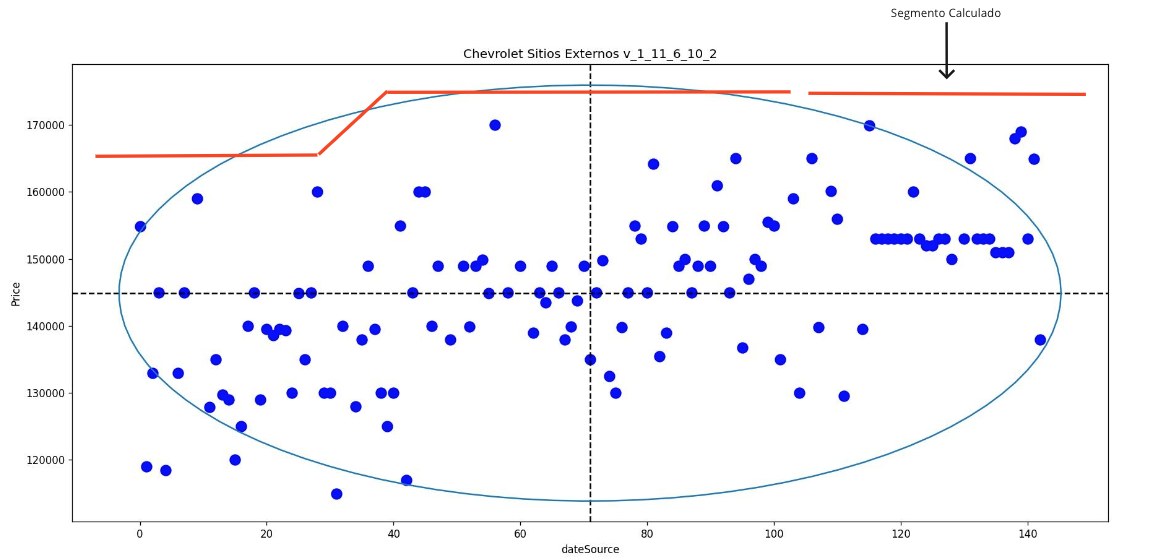

In [1]:
from IPython.display import Image
Image(filename='img_1.png',width=800, height=400)

In [ ]:
                    # Recolección de información por estado y país
                    if anuncios.empty == False:
                        anuncios['counting'] = [i for i in range(1, len(anuncios.index.values) + 1)]
                        # Eliminar los outliers en anuncios mediante clustering
                        prices = np.array(anuncios.price.values)
                        x_vector = np.array(anuncios.counting.values)
                        media = (prices).mean()
                        media_y = (x_vector).mean()
                        std_x = (prices).std() * 1.3  ### factor
                        std_y = (x_vector).std() * 1.3

                        # if int(anuncios.counting[-1]) <= 5:
                        #     std_x = (prices).std() * 1.3  ### factor
                        #     # std_y = (x_vector).std() * 1.3

                        if int(anuncios.counting[-1]) < 13:
                            std_x = (prices).std() * 1.4  ### factor
                            # std_y = (x_vector).std() * 1.4

                        elif 12 < int(anuncios.counting[-1]) < 22:
                            std_x = (prices).std() * 1.6  ### factor
                            # std_y = (x_vector).std() * 1.6

                        elif 22 < int(anuncios.counting[-1]):
                            std_x = (prices).std() * 1.8  ### factor
                            # std_y = (x_vector).std() * 1.8

                        anuncios.index = anuncios.counting
                        colors = ['blue'] * len(prices)
                        for index, x in enumerate(prices):
                            if abs(x - media) > std_x:
                                colors[index] = 'red'
                                # anomalia = anuncios.loc[anuncios.price == x]

                                anuncios.drop(index=anuncios.loc[anuncios.price == x].index, inplace=True)
                                # todas_las_anomalias_sites = pd.concat([anomalia, todas_las_anomalias_sites])

                        # fig, ax = plt.subplots(figsize=(18, 8), dpi=120)
                        # prices = np.array(anuncios.price.values)
                        # x_vector = np.array(anuncios.index.values)
                        #
                        # ax.scatter(x_vector, prices, s=100, color='blue')
                        # # ax.plot(df.index, df.price, color='red')
                        # ax.axhline(media, color='k', linestyle='--')
                        # ax.axvline(media_y, color='k', linestyle='--')
                        #
                        # v = media  # y-position of the center
                        # u = media_y  # x-position of the center
                        # b = std_x  # radius on the y-axis
                        # a = std_y  # radius on the x-axis
                        #
                        # t = np.linspace(0, 2 * pi, 100)
                        #
                        # ax.plot(u + a * np.cos(t), v + b * np.sin(t))
                        # plt.title(brand + ' Sitios Externos ' + cat)
                        # plt.xlabel('dateSource')
                        # plt.ylabel('Price')
                        # plt.show()
                        # plt.close(fig)

                        anuncios['lastProcessed'] = anuncios['lastProcessed'].dt.strftime('%Y-%m-01')
                        anuncios['lastProcessed'] = pd.to_datetime(anuncios['lastProcessed'])
                        
                        

<p>Once the prices are collected and converted into a data frame, the ad prices are filtered through an Inductive Clustering in an orderly manner. The blue points represent the ads that fall within the valid range, estimated from the average distance between each of the points, while the red points are those ads that have a longer distance compared to the average distance, and therefore they are discarded.</p>


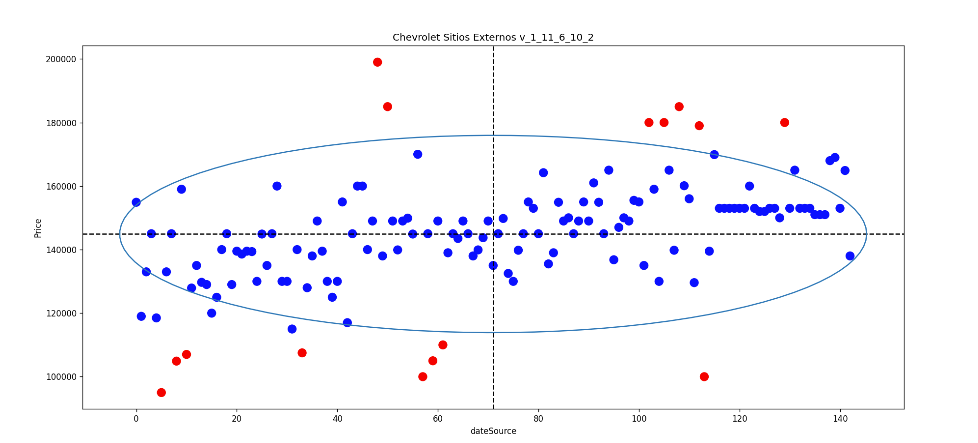

In [2]:
from IPython.display import Image
Image(filename='img.png',width=800, height=400)

In [ ]:

                        if len(list(anuncios.stateId.values)) > 0 and anuncios['stateId'].isnull().all() == False:
                            externalState = {i: list(anuncios.stateId.values).count(i) for i in anuncios.stateId.values}
                            externalState = {i: externalState[i] for i in externalState if i != None or str(i) != 'nan'}
                            externalState = {i: externalState[i] for i in externalState.keys() if str(i) != 'nan'}
                            if externalState == {}:
                                externalState = 0

                        if len(list(anuncios.country.values)) > 0 and anuncios['country'].isnull().all() == False:
                            country = {i: list(anuncios.country.values).count(i) for i in anuncios.country.values}
                            country = {i: country[i] for i in country if i != None or str(i) != 'nan'}
                            country = {i: country[i] for i in country.keys() if str(i) != 'nan'}

                            if country == {}:
                                country = 0

                        fechaInicio = anuncios.lastProcessed.values[0]
                        fechaFinal = anuncios.lastProcessed.values[-1]
                        range_fechas = pd.date_range(start=fechaInicio, end=fechaFinal, freq='MS')
                        weightPerDateSites = pd.DataFrame(data=[], index=range_fechas,
                                                          columns=['monthWeight', 'MLM', 'SMM', 'SAM'])
                        weightPerDateSites.monthWeight.replace(to_replace=np.NaN, value=0, inplace=True)
                        # weightPerDateSites.index = weightPerDateSites.index.dt.strftime('%Y-%m-01')
                        # weightPerDateSites.index = pd.to_datetime(weightPerDateSites.index)
                        # print(anuncios.to_string())
                        for date in weightPerDateSites.index:
                            muestraMLM = anuncios.loc[anuncios.siteId == 'MLM']
                            muestraSMM = anuncios.loc[anuncios.siteId == 'SMM']
                            muestraSAM = anuncios.loc[anuncios.siteId == 'SAM']

                            mlmW = len(muestraMLM[muestraMLM.lastProcessed == date].index.values)
                            smmW = len(muestraSMM[muestraSMM.lastProcessed == date].index.values)
                            samW = len(muestraSAM[muestraSAM.lastProcessed == date].index.values)
                            numero = len(anuncios[anuncios.lastProcessed == date].index.values)

                            weightPerDateSites.at[date, 'MLM'] = mlmW
                            weightPerDateSites.at[date, 'SMM'] = smmW
                            weightPerDateSites.at[date, 'SAM'] = samW
                            weightPerDateSites.at[date, 'monthWeight'] = numero

                        mlmWeight = [int(muestra) for muestra in np.reshape(weightPerDateSites['MLM'].values, (-1))]
                        smmWeight = [int(muestra) for muestra in np.reshape(weightPerDateSites['SMM'].values, (-1))]
                        samWeight = [int(muestra) for muestra in np.reshape(weightPerDateSites['SAM'].values, (-1))]

                        quantiles_agruppation = pd.concat([quantiles_agruppation, anuncios])

                        if anuncios.loc[anuncios['siteId'] == 'MLM'].empty != True and sum(mlmWeight) > sum(
                                smmWeight) / 1.5 and sum(mlmWeight) > 12:
                            anuncios = anuncios.loc[anuncios['siteId'] == 'MLM']

                        # PROCESAMIENTO DE ANUNCIOS A NIVEL ESTADO Y ZONA ECONÓMICA
                        anuncios_aux = anuncios

                        anuncios_aux = anuncios_aux[
                            ['categoryId', 'lastProcessed', 'state', 'stateId', 'price', 'economicZone']]
                        anuncios_aux['stateId'].replace('Null', np.nan, inplace=True)
                        anuncios_aux.dropna(subset=['stateId'], inplace=True)
                        state_code_anun = np.unique(anuncios_aux.stateId).tolist()
                        groups_of_anuncios_aux = anuncios_aux.groupby(anuncios_aux.stateId)
                        dataframe_stateId_anuncios_aux = pd.DataFrame()
                        for state in state_code_anun:
                            agrupamiento_estados_sitios = groups_of_anuncios_aux.get_group(state)
                            economicZone = agrupamiento_estados_sitios.iloc[0]['economicZone']
                            agrupamiento_estados_sitios['lastProcessed'] = pd.to_datetime(
                                agrupamiento_estados_sitios['lastProcessed'])
                            agrupamiento_estados_sitios = agrupamiento_estados_sitios['price'].groupby(
                                agrupamiento_estados_sitios['lastProcessed']).mean()

                            frecIsOk = True
                            len1 = len(agrupamiento_estados_sitios)
                            range_fechas = pd.date_range(start=agrupamiento_estados_sitios.index.values[0],
                                                         end=agrupamiento_estados_sitios.index.values[-1], freq='MS')
                            agrupamiento_estados_sitios = agrupamiento_estados_sitios.reindex(range_fechas,
                                                                                              fill_value=np.nan)
                            len2 = len(agrupamiento_estados_sitios)

                            if len1 != len2:
                                frecIsOk = False

                            agrupamiento_estados_sitios = agrupamiento_estados_sitios.to_frame()
                            agrupamiento_estados_sitios = agrupamiento_estados_sitios.assign(stateId=state)
                            agrupamiento_estados_sitios = agrupamiento_estados_sitios.assign(economicZone=economicZone)
                            agrupamiento_estados_sitios = agrupamiento_estados_sitios.assign(
                                lastProcessed=agrupamiento_estados_sitios.index)

                            if frecIsOk:
                                agrupamiento_estados_sitios.reset_index(drop=True, inplace=True)
                                agrupamiento_estados_sitios = agrupamiento_estados_sitios[
                                    ['stateId', 'economicZone', 'lastProcessed', 'price']]

                                # list_df_stateId_anuncios_aux.append(agrupamiento_estados_sitios)
                                # display(agrupamiento_estados_sitios)
                                dataframe_stateId_anuncios_aux = pd.concat(
                                    [dataframe_stateId_anuncios_aux, agrupamiento_estados_sitios])

                            if frecIsOk == False:
                                df_r = update_forecast_from_dataframe_one_column(agrupamiento_estados_sitios, 'price',
                                                                                 'lastProcessed')
                                agrupamiento_estados_sitios.reset_index(drop=True, inplace=True)
                                agrupamiento_estados_sitios.drop(['price'], axis=1, inplace=True)
                                agrupamiento_estados_sitios = agrupamiento_estados_sitios.merge(df_r,
                                                                                                on='lastProcessed',
                                                                                                how='left')
                                dataframe_stateId_anuncios_aux = pd.concat(
                                    [dataframe_stateId_anuncios_aux, agrupamiento_estados_sitios])

                        if anuncios.empty == False:

In [ ]:

                            anuncios['lastProcessed'] = pd.to_datetime(anuncios['lastProcessed'],
                                                                       infer_datetime_format=True)
                            anuncios = anuncios['price'].groupby(anuncios['lastProcessed'].dt.to_period('M')).mean()

                            anuncios.dropna(inplace=True)
                            anuncios = anuncios.astype({'price': 'int'})
                            siteAdsData = True
                            anuncios = anuncios.to_frame()

                            anuncios.index = anuncios.index.to_timestamp('s').strftime('%Y-%m-%d')
                            anuncios.index = pd.to_datetime(anuncios.index, format='%Y-%m-%d')
                            anuncios.sort_index(inplace=True)
                            range_fechas = pd.date_range(start=anuncios.index[0], end=anuncios.index[-1], freq='MS')
                            anuncios = anuncios.reindex(range_fechas, fill_value=0)

                            anuncios['lastProcessed'] = anuncios.index
                            anuncios.reset_index(drop=True, inplace=True)

                            valores_a_comparar = [row for (index, row) in anuncios.iterrows()]
                            lista_valores_intermediosSale = anuncios.index.to_list()

                            # Eliminación de picos
                            for valor in lista_valores_intermediosSale[1:-1]:

                                precio_anterior = valores_a_comparar[valor - 1]['price']
                                precio_actual = valores_a_comparar[valor]['price']
                                precio_siguiente = valores_a_comparar[valor + 1]['price']
                                notZero = (precio_anterior != 0 and precio_actual != 0 and precio_siguiente != 0)
                                if notZero:

                                    diferencia_atras = (-(100 - precio_actual / (precio_anterior / 100)))
                                    diferencia_adelante = (-(100 - precio_actual / (precio_siguiente / 100)))

                                    if ((precio_actual / (precio_anterior / 100) - 100) + (
                                            precio_actual / (precio_siguiente / 100) - 100)) / 2 >= 10 and \
                                            (
                                                    diferencia_adelante > diferencia_atras * 0.6 and diferencia_atras > diferencia_adelante * 0.6):

                                        anuncios.at[valor, 'price'] = (precio_anterior + precio_siguiente) / 2
                                        valores_a_comparar = [row for (index, row) in anuncios.iterrows()]

                                    elif ((-(100 - precio_actual / (precio_anterior / 100))) + (
                                            -(100 - precio_actual / (precio_siguiente / 100)))) / 2 <= -10 and \
                                            (
                                                    diferencia_adelante > diferencia_atras * 0.6 and diferencia_atras > diferencia_adelante * 0.6):

                                        anuncios.at[valor, 'price'] = (precio_anterior + precio_siguiente) / 2
                                        valores_a_comparar = [row for (index, row) in anuncios.iterrows()]
                                else:
                                    continue

<p style="margin-bottom:25px">Finally, a process is carried out to eliminate anomalies if there are any, iterating and taking segments of 3 prices to assess whether there is a rise or a fall. The algorithm is calibrated to detect peaks of 60%. This is a simple algorithm.</p>

<p>Before</p>

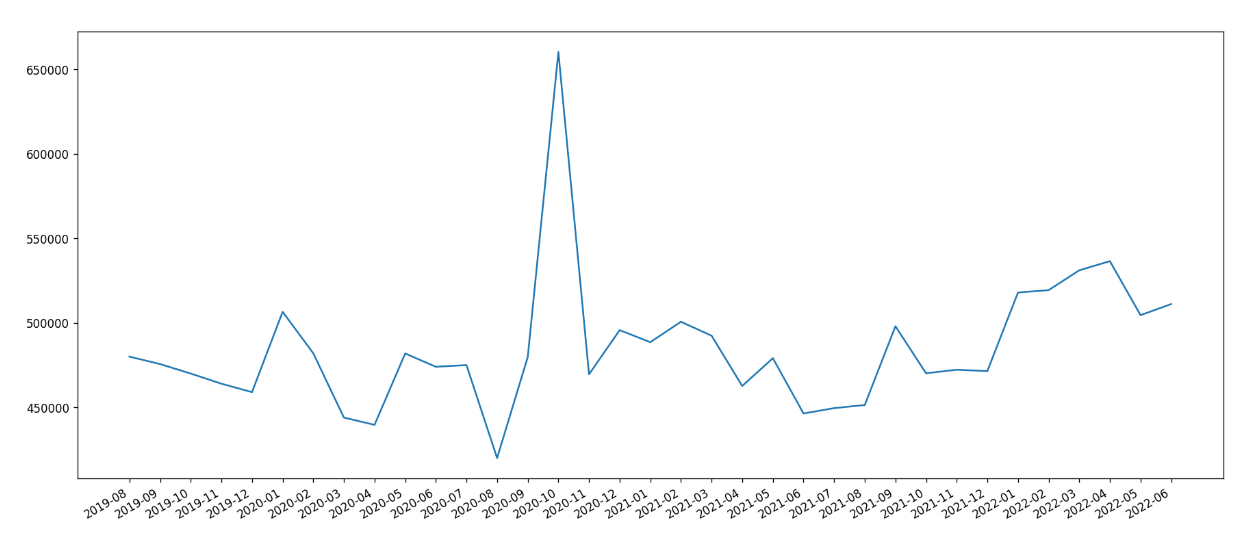

In [3]:
from IPython.display import Image
Image(filename='img_2.png',width=800, height=400)

<p>Then.</p>


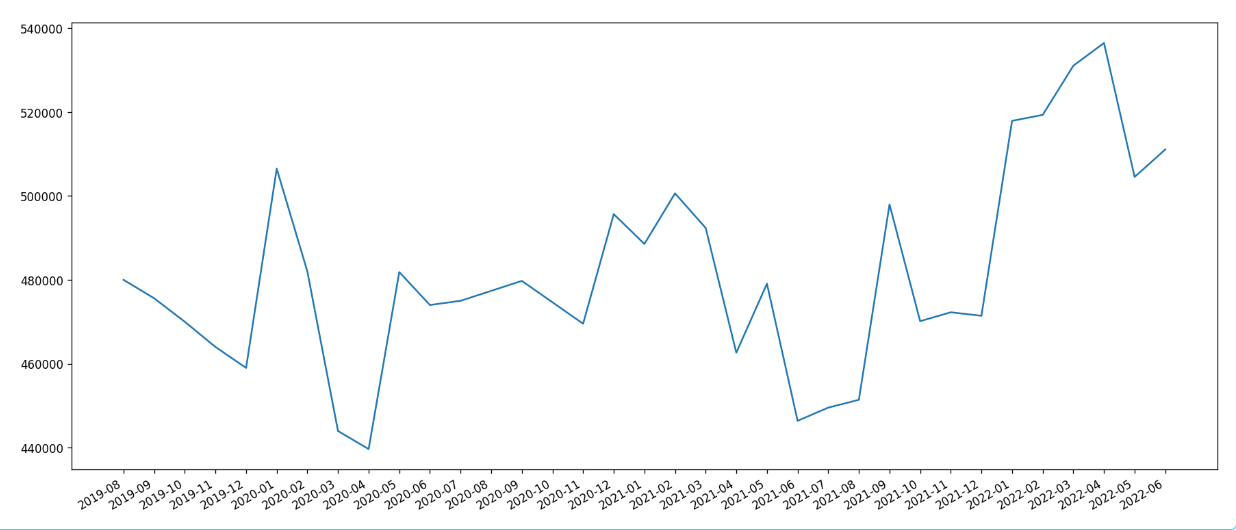

In [4]:
from IPython.display import Image
Image(filename='img_3.png',width=800, height=400)

In [ ]:

                            anuncios['price'].replace(0, np.nan, inplace=True)
                            anuncios = update_forecast_from_dataframe_one_column(anuncios, 'price', 'lastProcessed')
                            anuncios.index = anuncios['lastProcessed']
                            anuncios.drop(['lastProcessed'], axis=1, inplace=True)
                            anuncios.index = pd.to_datetime(anuncios.index, format='%Y-%m-%d')
                            # anuncios = anuncios.loc[anuncios['site']]
                            frames.append(anuncios)
                            anuncios['price'] = anuncios['price'].apply(lambda x: math.floor(x / 100) * 100)
                            x_anuncios = [str(date).strip(' 00:00:00') for date in np.reshape(anuncios.index, (-1))]
                            y_anuncios = [int(precio) for precio in np.reshape(anuncios.values, (-1))]

                        else:
                            siteAdsData = False
                            x_anuncios = None
                            y_anuncios = None
                    else:
                        siteAdsData = False
                        x_anuncios = None
                        y_anuncios = None

                else:
                    siteAdsData = False
                    x_anuncios = None
                    y_anuncios = None

                # eliminación de anomalías y precios fuera de rango (ENTERPRISE)
                if ads.empty == False and ads.price.values.all() != None:

                    anunciosMaxi = ads
                    anunciosMaxi['lastProcessed'] = pd.to_datetime(anunciosMaxi['lastProcessed'],
                                                                   infer_datetime_format=True).dt.strftime('%Y-%m-01')
                    anunciosMaxi['lastProcessed'] = pd.to_datetime(anunciosMaxi['lastProcessed'])

                    anunciosMaxiFiltrados = pd.DataFrame(data=[], index=[])
                    anunciosMaxi = anunciosMaxi.sort_values('lastProcessed')

                    if limit and anunciosMaxi.empty == False:

                        news_range = pd.date_range(start=df.index.values[0], end=df.index.values[-1], freq='MS')
                        anunciosRange = pd.date_range(start=anunciosMaxi.lastProcessed.values[0],
                                                      end=anunciosMaxi.lastProcessed.values[-1], freq='MS')
                        backward_range = pd.date_range(start=df.index.values[0],
                                                       end=anunciosMaxi.lastProcessed.values[-1],
                                                       freq='MS')

                        forward_range = pd.date_range(start=anunciosMaxi.lastProcessed.values[0],
                                                      end=df.index.values[-1],
                                                      freq='MS')

                        comparativaMaxi = df
                        comparativaMaxi.dateCreated = pd.to_datetime(comparativaMaxi.dateCreated)

                        llegaMasLejos = news_range.tolist()[-1] >= anunciosRange.tolist()[-1]
                        llegaMasAtras = news_range.tolist()[0] <= anunciosRange.tolist()[0]

                        if not llegaMasAtras and not llegaMasLejos:
                            extendedBackward = comparativaMaxi.price.values[0]
                            extendedForward = comparativaMaxi.price.values[-1]
                            comparativaMaxi = comparativaMaxi.reindex(anunciosRange, fill_value=np.nan)
                            comparativaMaxi['dateCreated'] = comparativaMaxi.index
                            comparativaMaxi.reset_index(drop=True, inplace=True)
                            comparativaMaxi.at[comparativaMaxi.index.values[0], 'price'] = extendedBackward
                            comparativaMaxi.at[comparativaMaxi.index.values[-1], 'price'] = extendedForward
                            comparativaMaxi = update_forecast_from_dataframe_one_column(comparativaMaxi, 'price',
                                                                                        'dateCreated')

                        elif llegaMasAtras and not llegaMasLejos:
                            extendedForward = comparativaMaxi.price.values[-1]
                            comparativaMaxi['dateCreated'] = comparativaMaxi.index
                            comparativaMaxi.reset_index(drop=True, inplace=True)
                            insertion = pd.DataFrame({'price': [extendedForward],
                                                      'dateCreated': [backward_range[-1]]})
                            comparativaMaxi = pd.concat([comparativaMaxi, insertion])
                            comparativaMaxi.index = comparativaMaxi['dateCreated']
                            comparativaMaxi.index.name = None
                            comparativaMaxi.sort_values(by='dateCreated', axis=0, inplace=True)

                            comparativaMaxi.drop_duplicates(inplace=True)
                            comparativaMaxi = comparativaMaxi['price'].groupby(comparativaMaxi.dateCreated).mean()
                            comparativaMaxi = pd.DataFrame(data=comparativaMaxi.values,
                                                           index=comparativaMaxi.index.values,
                                                           columns=['price'])

                            comparativaMaxi = comparativaMaxi.reindex(backward_range, fill_value=np.nan)

                            comparativaMaxi['dateCreated'] = comparativaMaxi.index
                            comparativaMaxi.reset_index(drop=True, inplace=True)
                            comparativaMaxi.at[comparativaMaxi.index.values[-1], 'price'] = extendedForward
                            comparativaMaxi = update_forecast_from_dataframe_one_column(comparativaMaxi, 'price',
                                                                                        'dateCreated')

                        elif llegaMasLejos and not llegaMasAtras:

                            extendedBackward = comparativaMaxi.price.values[0]
                            comparativaMaxi['dateCreated'] = comparativaMaxi.index
                            comparativaMaxi.reset_index(drop=True, inplace=True)
                            insertion = pd.DataFrame({'price': [extendedBackward],
                                                      'dateCreated': [forward_range[-1]]})
                            comparativaMaxi = pd.concat([comparativaMaxi, insertion])
                            comparativaMaxi.index.name = None
                            comparativaMaxi.sort_values(by='dateCreated', axis=0, inplace=True)
                            comparativaMaxi.index = comparativaMaxi['dateCreated']

                            comparativaMaxi.drop_duplicates(inplace=True)
                            comparativaMaxi = comparativaMaxi['price'].groupby(comparativaMaxi.dateCreated).mean()
                            comparativaMaxi = pd.DataFrame(data=comparativaMaxi.values,
                                                           index=comparativaMaxi.index.values,
                                                           columns=['price'])

                            comparativaMaxi = comparativaMaxi.reindex(forward_range, fill_value=np.nan)
                            comparativaMaxi['dateCreated'] = comparativaMaxi.index
                            comparativaMaxi.reset_index(drop=True, inplace=True)
                            comparativaMaxi.at[comparativaMaxi.index.values[0], 'price'] = extendedBackward

                            comparativaMaxi = update_forecast_from_dataframe_one_column(comparativaMaxi, 'price',
                                                                                        'dateCreated')

                        for date in anunciosMaxi.lastProcessed.drop_duplicates():
                            precios = anunciosMaxi.loc[anunciosMaxi.lastProcessed == date]
                            limite = comparativaMaxi.loc[comparativaMaxi.dateCreated == date].price.values[0]
                            precios = precios.loc[precios.price < limite]
                            anunciosMaxiFiltrados = pd.concat([anunciosMaxiFiltrados, precios])

                    if limit:
                        df.index = df.dateCreated
                        anunciosMaxi = anunciosMaxiFiltrados

                    if anunciosMaxi.empty is not True:

                        anunciosMaxi['counting'] = [i for i in range(0, len(anunciosMaxi.index.values))]
                        prices = np.array(anunciosMaxi.price.values)
                        x_vector = np.array(anunciosMaxi.counting.values)
                        media = (prices).mean()
                        # media_y = (x_vector).mean()
                        std_x = (prices).std() * 1.3  ### factor
                        # std_y = (x_vector).std() * 1.3

                        # if int(anunciosMaxi.counting[-1]) <= 5:
                        #     std_x = (prices).std() * 1.3
                        #     # std_y = (x_vector).std() * 1.3

                        if int(anunciosMaxi.counting[-1]) < 13:
                            std_x = (prices).std() * 1.4
                            # std_y = (x_vector).std() * 1.4

                        elif 12 < int(anunciosMaxi.counting[-1]) < 22:
                            std_x = (prices).std() * 1.6
                            # std_y = (x_vector).std() * 1.6

                        elif 22 < int(anunciosMaxi.counting[-1]):
                            std_x = (prices).std() * 1.8
                            # std_y = (x_vector).std() * 1.8

                        colors = ['blue'] * len(prices)

                        anunciosMaxi.index = anunciosMaxi.counting
                        for index, x in enumerate(prices):
                            if abs(x - media) > std_x:
                                colors[index] = 'red'
                                # anomalia = anunciosMaxi.loc[anunciosMaxi.price == x]

                                anunciosMaxi.drop(index=anunciosMaxi.loc[anunciosMaxi.price == x].index, inplace=True)
                                # todas_las_anomalias_Maxi = pd.concat([anomalia, todas_las_anomalias_Maxi])

                        anunciosMaxi['lastProcessed'] = anunciosMaxi['lastProcessed'].dt.strftime('%Y-%m-01')
                        anunciosMaxi['lastProcessed'] = pd.to_datetime(anunciosMaxi['lastProcessed'])

                        # fig, ax = plt.subplots(figsize=(18, 8), dpi=120)
                        # ax.scatter(x_vector, prices, s=100, color=colors)
                        # ax.axhline(media, color='k', linestyle='--')
                        # ax.axvline(media_y, color='k', linestyle='--')
                        #
                        # v = media  # y-position of the center
                        # u = media_y  # x-position of the center
                        # b = std_x  # radius on the y-axis
                        # a = std_y  # radius on the x-axis
                        #
                        # t = np.linspace(0, 2 * pi, 100)
                        #
                        # ax.plot(u + a * np.cos(t), v + b * np.sin(t))
                        #
                        # plt.title(brand + ' ENTERPRISE ' + cat)
                        # plt.xlabel('dateSource')
                        # plt.ylabel('Price')
                        # plt.show()
                        # plt.close(fig)
                        # Recolección de información por estado y país
                        if len(list(anunciosMaxi.state.values)) > 0 and anunciosMaxi['state'].isnull().all() == False:
                            MPstate = {i: list(anunciosMaxi.state.values).count(i) for i in anunciosMaxi.state.values}
                            MPstate = {i: MPstate[i] for i in MPstate if i != None or str(i) != 'nan'}
                            MPstate = {i: MPstate[i] for i in MPstate.keys() if str(i) != 'nan'}

                            if MPstate == {}:
                                MPstate = 0

                        quantiles_agruppation = pd.concat([quantiles_agruppation, anunciosMaxi])

                        if len(list(anunciosMaxi.country.values)) > 0 and anunciosMaxi[
                            'country'].isnull().all() == False:
                            MPcountry = {i: list(anunciosMaxi.country.values).count(i) for i in
                                         anunciosMaxi.country.values}
                            MPcountry = {i: MPcountry[i] for i in MPcountry if i != None or str(i) != 'nan'}
                            MPcountry = {i: MPcountry[i] for i in MPcountry.keys() if str(i) != 'nan'}
                            if MPcountry == {}:
                                MPcountry = 0

                        fechaInicio = anunciosMaxi.lastProcessed.values[0]
                        fechaFinal = anunciosMaxi.lastProcessed.values[-1]
                        range_fechas = pd.date_range(start=fechaInicio, end=fechaFinal, freq='MS')
                        weightPerDateMaxi = pd.DataFrame(data=[], index=range_fechas,
                                                         columns=['monthWeight'])
                        weightPerDateMaxi.monthWeight.replace(to_replace=np.NaN, value=0, inplace=True)
                        for date in weightPerDateMaxi.index:
                            numero = len(anunciosMaxi[anunciosMaxi.lastProcessed == date].index.values)
                            weightPerDateMaxi.at[date, 'monthWeight'] = numero

                        # PROCESAMIENTO DE ANUNCIOS A NIVEL ESTADO Y ZONA ECONÓMICA ANUNCIOS ENTERPRISE
                        # print(anunciosMaxi.to_string())

                        anunciosMaxi_aux = anunciosMaxi
                        anunciosMaxi_aux = anunciosMaxi_aux[
                            ['categoryId', 'lastProcessed', 'state', 'price', 'economicZone']]
                        anunciosMaxi_aux['state'].replace('Null', np.nan, inplace=True)
                        anunciosMaxi_aux.dropna(subset=['state'], inplace=True)
                        state_code_maxi = np.unique(anunciosMaxi_aux.state).tolist()
                        groups_of_anunciosMaxi_aux = anunciosMaxi_aux.groupby(anunciosMaxi_aux.state)
                        dataframe_stateId_maxi = pd.DataFrame()

                        for state in state_code_maxi:
                            agrupamiento_estados_maxi = groups_of_anunciosMaxi_aux.get_group(state)
                            economicZone = agrupamiento_estados_maxi.iloc[0]['economicZone']
                            agrupamiento_estados_maxi['lastProcessed'] = pd.to_datetime(
                                agrupamiento_estados_maxi['lastProcessed'])
                            agrupamiento_estados_maxi = agrupamiento_estados_maxi['price'].groupby(
                                agrupamiento_estados_maxi['lastProcessed']).mean()
                            frecIsOk = True
                            len1 = len(agrupamiento_estados_maxi)
                            range_fechas = pd.date_range(start=agrupamiento_estados_maxi.index.values[0],
                                                         end=agrupamiento_estados_maxi.index.values[-1], freq='MS')
                            agrupamiento_estados_maxi = agrupamiento_estados_maxi.reindex(range_fechas,
                                                                                          fill_value=np.nan)
                            len2 = len(agrupamiento_estados_maxi)

                            if len1 != len2:
                                frecIsOk = False

                            agrupamiento_estados_maxi = agrupamiento_estados_maxi.to_frame()
                            agrupamiento_estados_maxi = agrupamiento_estados_maxi.assign(stateId=state)
                            agrupamiento_estados_maxi = agrupamiento_estados_maxi.assign(economicZone=economicZone)
                            agrupamiento_estados_maxi = agrupamiento_estados_maxi.assign(
                                lastProcessed=agrupamiento_estados_maxi.index)

                            if frecIsOk:
                                agrupamiento_estados_maxi.reset_index(drop=True, inplace=True)
                                agrupamiento_estados_maxi = agrupamiento_estados_maxi[
                                    ['stateId', 'economicZone', 'lastProcessed', 'price']]
                                # list_df_stateId_maxi.append(agrupamiento_estados_maxi)
                                dataframe_stateId_maxi = pd.concat([dataframe_stateId_maxi, agrupamiento_estados_maxi])
                                # display(agrupamiento_estados_maxi)

                            if frecIsOk == False:
                                df_r = update_forecast_from_dataframe_one_column(agrupamiento_estados_maxi, 'price',
                                                                                 'lastProcessed')
                                agrupamiento_estados_maxi.reset_index(drop=True, inplace=True)
                                agrupamiento_estados_maxi.drop(['price'], axis=1, inplace=True)
                                agrupamiento_estados_maxi = agrupamiento_estados_maxi.merge(df_r, on='lastProcessed',
                                                                                            how='left')
                                # list_df_stateId_maxi.append(agrupamiento_estados_maxi)
                                dataframe_stateId_maxi = pd.concat([dataframe_stateId_maxi, agrupamiento_estados_maxi])

                        anunciosMaxi = anunciosMaxi['price'].groupby(
                            anunciosMaxi['lastProcessed'].dt.to_period('M')).mean()
                        anunciosMaxi.dropna(inplace=True)
                        anunciosMaxi = anunciosMaxi.astype({'price': 'int'})
                        adsMxMxpData = True
                        anunciosMaxi = anunciosMaxi.to_frame()

                        anunciosMaxi.index = anunciosMaxi.index.to_timestamp('s').strftime('%Y-%m-%d')
                        anunciosMaxi.index = pd.to_datetime(anunciosMaxi.index, format='%Y-%m-%d')
                        anunciosMaxi.sort_index(inplace=True)
                        range_fechas = pd.date_range(start=anunciosMaxi.index[0], end=anunciosMaxi.index[-1], freq='MS')
                        anunciosMaxi = anunciosMaxi.reindex(range_fechas, fill_value=0)

                        anunciosMaxi['lastProcessed'] = anunciosMaxi.index
                        anunciosMaxi.reset_index(drop=True, inplace=True)

                        valores_a_comparar = [row for (index, row) in anunciosMaxi.iterrows()]
                        lista_valores_intermediosSale = anunciosMaxi.index.to_list()

                        # Eliminación de picos
                        for valor in lista_valores_intermediosSale[1:-1]:

                            precio_anterior = valores_a_comparar[valor - 1]['price']
                            precio_actual = valores_a_comparar[valor]['price']
                            precio_siguiente = valores_a_comparar[valor + 1]['price']
                            notZero = (precio_anterior != 0 and precio_actual != 0 and precio_siguiente != 0)
                            if notZero:
                                diferencia_atras = (-(100 - precio_actual / (precio_anterior / 100)))
                                diferencia_adelante = (-(100 - precio_actual / (precio_siguiente / 100)))

                                if ((precio_actual / (precio_anterior / 100) - 100) + (
                                        precio_actual / (precio_siguiente / 100) - 100)) / 2 >= 10 and \
                                        (
                                                diferencia_adelante < diferencia_atras * 0.6 and diferencia_atras < diferencia_adelante * 0.6):
                                    anunciosMaxi.at[valor, 'price'] = (precio_anterior + precio_siguiente) / 2
                                    valores_a_comparar = [row for (index, row) in anunciosMaxi.iterrows()]

                                elif ((-(100 - precio_actual / (precio_anterior / 100))) + (
                                        -(100 - precio_actual / (precio_siguiente / 100)))) / 2 <= -10 and \
                                        (
                                                diferencia_adelante > diferencia_atras * 0.6 and diferencia_atras > diferencia_adelante * 0.6):

                                    anunciosMaxi.at[valor, 'price'] = (precio_anterior + precio_siguiente) / 2
                                    valores_a_comparar = [row for (index, row) in anunciosMaxi.iterrows()]
                            else:
                                continue

                        anunciosMaxi['price'].replace(0, np.nan, inplace=True)
                        anunciosMaxi = update_forecast_from_dataframe_one_column(anunciosMaxi, 'price', 'lastProcessed')
                        anunciosMaxi.index = anunciosMaxi['lastProcessed']
                        anunciosMaxi.drop(['lastProcessed'], axis=1, inplace=True)
                        anunciosMaxi.index = pd.to_datetime(anunciosMaxi.index, format='%Y-%m-%d')
                        frames.append(anunciosMaxi)
                        anunciosMaxi['price'] = anunciosMaxi['price'].apply(lambda x: math.floor(x / 100) * 100)
                        x_maxi = [str(date).strip(' 00:00:00') for date in np.reshape(anunciosMaxi.index, (-1))]
                        y_maxi = [int(precio) for precio in np.reshape(anunciosMaxi.values, (-1))]

                    else:
                        adsMxMxpData = False
                        x_maxi = None
                        y_maxi = None
                else:
                    adsMxMxpData = False
                    x_maxi = None
                    y_maxi = None

                # eliminación de anomalías y precios fuera de rango (EBC)
                if ebc.empty == False and ebc.price.isnull().all() == False:
                    ebc.dateCreated = pd.to_datetime(ebc['dateCreated'], infer_datetime_format=True).dt.strftime(
                        '%Y-%m-%d')
                    ebc['dateCreated'] = pd.to_datetime(ebc['dateCreated'])
                    ebc = ebc['price'].groupby(ebc['dateCreated'].dt.to_period('M')).mean()
                    ebc.dropna(inplace=True)
                    ebc = ebc.astype({'price': 'int'})
                    ebcData = True
                    ebc = ebc.to_frame()
                    ebc.index = ebc.index.to_timestamp('s').strftime('%Y-%m-%d')
                    ebc.index = pd.to_datetime(ebc.index, format='%Y-%m-%d')
                    ebc.sort_index(inplace=True)
                    range_fechas = pd.date_range(start=ebc.index[0], end=ebc.index[-1], freq='MS')
                    ebc = ebc.reindex(range_fechas, fill_value=np.nan)

                    if ebc['price'].isnull().values.any():
                        ebc['createdDate'] = ebc.index
                        ebc = update_forecast_from_dataframe_one_column(ebc, 'price', 'createdDate')
                        ebc.index = ebc['createdDate']
                        ebc.drop(labels='createdDate', axis=1, inplace=True)
                    ebc.index = pd.to_datetime(ebc.index, format='%Y-%m-%d')

                    today = dt.today()
                    MS = dt(today.year, today.month, 1)

                    pasos = len(pd.date_range(start=ebc.index.values[0], end=MS, freq='MS').to_list()) - len(
                        ebc.index.values)
                    pasos += 3

                    ebc['dateSource'] = ebc.index
                    forecastEbc, intervaloEbc, approved = construct_dataframe_predict(dataframe_i=ebc, pasos=pasos,
                                                                                      column='price',
                                                                                      meses='auto', exog=False,
                                                                                      limite=ebc.price.values[-1])
                    if approved:
                        # ax.fill_between(
                        #     intervaloEbc.index,
                        #     intervaloEbc['lower_bound'],
                        #     intervaloEbc['upper_bound'],
                        #     color='blue',
                        #     alpha=0.2)

                        ebc.drop(labels=['dateSource'], axis=1, inplace=True)
                        forecastEbc = pd.DataFrame(index=forecastEbc.index, data=forecastEbc.values, columns=['price'])

                        x_ebc_forecast = [str(date).strip(' 00:00:00') for date in np.reshape(forecastEbc.index, (-1))]
                        y_ebc_forecast = [int(precio) for precio in np.reshape(forecastEbc.values, (-1))]

                        ebc = pd.concat([ebc, forecastEbc])

                        # upperEbc = pd.Series(data=intervaloEbc['upper_bound'].values, index=intervaloEbc.index.values)
                        # lowerEbc = pd.Series(data=intervaloEbc['lower_bound'].values, index=intervaloEbc.index.values)
                        upperEbc = [int(precio) for precio in np.reshape(intervaloEbc['upper_bound'].values, (-1))]
                        lowerEbc = [int(precio) for precio in np.reshape(intervaloEbc['lower_bound'].values, (-1))]

                        dentro_intervalo = np.where(
                            (forecastEbc.loc[forecastEbc.index, 'price'] >= intervaloEbc['lower_bound']) & \
                            (forecastEbc.loc[forecastEbc.index, 'price'] <= intervaloEbc['upper_bound']),
                            True,
                            False)
                        # cobertura = dentro_intervalo.mean()
                    else:
                        ebc.drop(labels=['dateSource'], axis=1, inplace=True)

                    ebc['price'] = ebc['price'].apply(lambda x: math.floor(x / 100) * 100)
                    emulation_frames.append(ebc)
                    ebc.price.dropna(axis=0, inplace=True)
                    x_ebc = [str(date).strip(' 00:00:00') for date in np.reshape(ebc.index, (-1))]
                    y_ebc = [int(precio) for precio in np.reshape(ebc.values, (-1))]

                else:
                    ebcData = False
                    x_ebc = None
                    y_ebc = None

                # eliminación de anomalías y precios fuera de rango (GAM)
                if gam.empty == False and gam.price.values.all() != None and (len(gam.index.values) != 1) and all(
                        [i > 0 for i in gam.price.values if str(i) != 'nan' or str(i) != 'NAN' or str(i) != 'NaN']
                ):

                    gam = gam
                    gam.dateCreated = pd.to_datetime(gam['dateCreated'], infer_datetime_format=True).dt.strftime(
                        '%Y-%m-%d')
                    gam['dateCreated'] = pd.to_datetime(gam['dateCreated'])

                    gam = gam['price'].groupby(gam['dateCreated'].dt.to_period('M')).mean()
                    gam = gam.astype({'price': 'int'})
                    gamData = True
                    gam = gam.to_frame()
                    gam.index = gam.index.to_timestamp('s').strftime('%Y-%m-%d')
                    gam.index = pd.to_datetime(gam.index, format='%Y-%m-%d')
                    gam.sort_index(inplace=True)
                    range_fechas = pd.date_range(start=gam.index[0], end=gam.index[-1], freq='MS')

                    gam = gam.reindex(range_fechas, fill_value=np.nan)
                    if gam['price'].isnull().values.any():
                        gam['createdDate'] = gam.index
                        gam = update_forecast_from_dataframe_one_column(gam, 'price', 'createdDate')
                        gam.index = gam['createdDate']
                        gam.drop(labels='createdDate', axis=1, inplace=True)

                    gam.index = pd.to_datetime(gam.index, format='%Y-%m-%d')

                    today = dt.today()
                    MS = dt(today.year, today.month, 1)

                    pasos = len(pd.date_range(start=gam.index.values[0], end=MS, freq='MS').to_list()) - len(
                        gam.index.values)
                    pasos += 3
                    gam['dateSource'] = gam.index
                    forecastGam, intervaloGam, approved = construct_dataframe_predict(dataframe_i=gam, pasos=pasos,
                                                                                      column='price',
                                                                                      meses='auto', exog=False,
                                                                                      limite=gam.price.values[-1])
                    if approved:
                        # ax.fill_between(
                        #     intervaloGam.index,
                        #     intervaloGam['lower_bound'],
                        #     intervaloGam['upper_bound'],
                        #     color='gray',
                        #     alpha=0.2)

                        gam.drop(labels=['dateSource'], axis=1, inplace=True)
                        forecastGam = pd.DataFrame(index=forecastGam.index, data=forecastGam.values, columns=['price'])

                        x_gam_forecast = [str(date).strip(' 00:00:00') for date in np.reshape(forecastGam.index, (-1))]
                        y_gam_forecast = [int(precio) for precio in np.reshape(forecastGam.values, (-1))]

                        gam = pd.concat([gam, forecastGam])
                        # upperGam = pd.Series(data=intervaloGam['upper_bound'].values, index=intervaloGam.index.values)
                        upperGam = [int(precio) for precio in np.reshape(intervaloGam['upper_bound'].values, (-1))]
                        lowerGam = [int(precio) for precio in np.reshape(intervaloGam['lower_bound'].values, (-1))]

                        # lowerGam = pd.Series(data=intervaloGam['lower_bound'].values, index=intervaloGam.index.values)
                        dentro_intervalo = np.where(
                            (forecastGam.loc[forecastGam.index, 'price'] >= intervaloGam['lower_bound']) & \
                            (forecastGam.loc[forecastGam.index, 'price'] <= intervaloGam['upper_bound']),
                            True,
                            False)
                        cobertura = dentro_intervalo.mean()
                    else:
                        gam.drop(labels=['dateSource'], axis=1, inplace=True)

                    gam['price'] = gam['price'].apply(lambda x: math.floor(x / 100) * 100)
                    # emulation_frames.append(gam)
                    x_gam = [str(date).strip(' 00:00:00') for date in np.reshape(gam.index, (-1))]
                    y_gam = [int(precio) for precio in np.reshape(gam.values, (-1))]
                else:
                    gamData = False
                    x_gam = None
                    y_gam = None

                # Si no hay anuncios
                if frames == []:
                    sin_anuncios = True
                    anuncios = pd.DataFrame(data=[], index=[])
                    if ebcData or gamData:
                        today = dt.today()
                        MS = dt(today.year, today.month, 1)

                        if ebcData and gamData:
                            ebcAltern = ebc
                            gamAltern = gam
                            precio = (ebcAltern.price.mean() + gamAltern.price.mean()) / 2
                            anuncios = pd.DataFrame(data=[precio], index=[MS], columns=['price'])

                        elif ebcData:
                            ebcAltern = ebc
                            precio = ebcAltern.price.mean()
                            anuncios = pd.DataFrame(data=[precio], index=[MS], columns=['price'])

                        elif gamData:
                            gamAltern = gam
                            precio = gamAltern.price.mean()
                            anuncios = pd.DataFrame(data=[precio], index=[MS], columns=['price'])

                        frames.append(anuncios)
                        weightPerDateSites = pd.DataFrame(data=[0], index=[MS], columns=['monthWeight'])

                descartar_señuelos = (flag != 'all' and sin_anuncios == True)

                # en caso de existir anuncios
                if frames != [] and descartar_señuelos == False:
                    price_hist_x = None
                    price_hist_y = None
                    odometer_hist_x = None
                    odometer_hist_y = None

                    if not sin_anuncios:
                        sections = [1, 0.75, 0.50, 0.25, 0.01]

                        quantiles = {str(i): np.quantile(quantiles_agruppation['price'], q=i) for i in sections}
                        quantiles_agruppation.sort_values(by='lastProcessed', axis=0, inplace=True)
                        quantiles_agruppation['counting'] = [i for i in
                                                             range(0, len(quantiles_agruppation.index.values))]
                        interquantiles = {
                            str(quantiles[i]):
                                len(quantiles_agruppation.loc[(quantiles_agruppation['price'] <= quantiles[i])
                                                              &
                                                              (quantiles_agruppation['price'] > quantiles[
                                                                  list(quantiles.keys())
                                                                  [list(quantiles.keys()).index(i) + 1]])].index.values)
                            for i in
                            quantiles.keys() if i != list(quantiles.keys())[-1]
                        }

                        odometer = [i for i in quantiles_agruppation['odometer'].values if
                                    i < np.mean(quantiles_agruppation['odometer']) * 2]

                        km_quantiles = {str(i): np.quantile(odometer, q=i) for i in sections}
                        km_interquantiles = {
                            str(km_quantiles[i]): len(
                                quantiles_agruppation.loc[(quantiles_agruppation['odometer'] <= km_quantiles[i]) &
                                                          (quantiles_agruppation['odometer'] > km_quantiles[
                                                              list(km_quantiles.keys())[
                                                                  list(km_quantiles.keys()).index(
                                                                      i) + 1]])].index.values)
                            for i in km_quantiles.keys() if i != list(km_quantiles.keys())[-1]}
                        price_hist_x = [i for i in interquantiles.keys()]
                        price_hist_y = [interquantiles[i] for i in interquantiles.keys()]
                        odometer_hist_x = [i for i in km_interquantiles.keys()]
                        odometer_hist_y = [km_interquantiles[i] for i in km_interquantiles.keys()]

                    # PROMEDIAR AMBAS FUENTES (MAXI Y SITIOS EXTERNOS) EN NIVELES ESTADOS Y ZONAS ECONÓMICAS
                    df_anuncios_ext_maxi = pd.concat([dataframe_stateId_maxi, dataframe_stateId_anuncios_aux])
                    if df_anuncios_ext_maxi.empty == False:
                        states = df_anuncios_ext_maxi.stateId.drop_duplicates().values
                        state_prices = {
                            i: {'suavizado': {'x': np.nan, 'y': np.nan}, 'noSuavizado': {'x': np.nan, 'y': np.nan}} for
                            i in states}
                        # df_anuncios_ext_maxi = pd.concat([dataframe_stateId_maxi,dataframe_stateId_anuncios_aux])
                        economicZones = df_anuncios_ext_maxi.economicZone.drop_duplicates().values
                        economic_zone_prices = {
                            i: {'suavizado': {'x': np.nan, 'y': np.nan}, 'noSuavizado': {'x': np.nan, 'y': np.nan}} for
                            i in economicZones}
                        for state in states:
                            prices = df_anuncios_ext_maxi.loc[df_anuncios_ext_maxi.stateId == state]
                            prices = prices.groupby('lastProcessed').agg({'price': pd.Series.mean})
                            range_fechas = pd.date_range(start=prices.index.values[0], end=prices.index.values[-1],
                                                         freq='MS')
                            prices = prices.reindex(range_fechas, fill_value=np.nan)
                            prices['lastProcessed'] = prices.index
                            prices['price'] = prices.values
                            prices = update_forecast_from_dataframe_one_column(prices, 'price', 'lastProcessed')
                            prices.index = range_fechas

                            x = [str(date).strip(' 00:00:00') for date in np.reshape(prices.index, (-1))]
                            y = [int(precio) for precio in np.reshape(prices['price'].values, (-1))]

                            state_prices[state]['noSuavizado']['x'] = x
                            state_prices[state]['noSuavizado']['y'] = y

                            prices = prices.rolling(5, min_periods=1, center=True, closed='both').mean()
                            prices = prices.rolling(5, min_periods=1, center=False, closed='both').mean()
                            today = dt.today()
                            MS = dt(today.year, today.month, 1)

                            pasos = len(
                                pd.date_range(start=prices.index.values[0], end=MS, freq='MS').to_list()) - len(
                                prices.index.values)
                            prices['lastUpdated'] = prices.index

                            if 0 < pasos <= 6 and len(prices.index.values) >= 3:
                                forecast, intervalo, approved = construct_dataframe_predict(dataframe_i=prices,
                                                                                            pasos=pasos,
                                                                                            column='price',
                                                                                            meses='auto', exog=ebc,
                                                                                            limite=prices.price.values[
                                                                                                -1],
                                                                                            fuente='geographic'
                                                                                            )
                                if approved:
                                    prices = pd.concat([prices, forecast])

                            x = [str(date).strip(' 00:00:00') for date in np.reshape(prices.index, (-1))]
                            y = [int(precio) for precio in np.reshape(prices['price'].values, (-1))]
                            state_prices[state]['suavizado']['x'] = x
                            state_prices[state]['suavizado']['y'] = y

                        for economicZone in economicZones:
                            prices = df_anuncios_ext_maxi.loc[df_anuncios_ext_maxi.economicZone == economicZone]
                            # print(prices)

                            prices = prices.groupby('lastProcessed').agg({'price': pd.Series.mean})

                            range_fechas = pd.date_range(start=prices.index.values[0], end=prices.index.values[-1],
                                                         freq='MS')
                            prices = prices.reindex(range_fechas, fill_value=np.nan)
                            prices['lastProcessed'] = prices.index
                            prices['price'] = prices.values
                            prices = update_forecast_from_dataframe_one_column(prices, 'price', 'lastProcessed')
                            prices.index = range_fechas

                            x = [str(date).strip(' 00:00:00') for date in np.reshape(prices.index, (-1))]
                            y = [int(precio) for precio in np.reshape(prices['price'].values, (-1))]
                            economic_zone_prices[economicZone]['noSuavizado']['x'] = x
                            economic_zone_prices[economicZone]['noSuavizado']['y'] = y

                            prices = prices.rolling(5, min_periods=1, center=True, closed='both').mean()
                            prices = prices.rolling(5, min_periods=1, center=False, closed='both').mean()

                            today = dt.today()
                            MS = dt(today.year, today.month, 1)

                            pasos = len(
                                pd.date_range(start=prices.index.values[0], end=MS, freq='MS').to_list()) - len(
                                prices.index.values)
                            prices['lastUpdated'] = prices.index

                            if 0 < pasos <= 6 and len(prices.index.values) >= 3:
                                forecast, intervalo, approved = construct_dataframe_predict(dataframe_i=prices,
                                                                                            pasos=pasos,
                                                                                            column='price',
                                                                                            meses='auto', exog=ebc,
                                                                                            limite=prices.price.values[
                                                                                                -1],
                                                                                            fuente='geographic'
                                                                                            )
                                if approved:
                                    prices = pd.concat([prices, forecast])

                            x = [str(date).strip(' 00:00:00') for date in np.reshape(prices.index, (-1))]
                            y = [int(precio) for precio in np.reshape(prices['price'].values, (-1))]
                            economic_zone_prices[economicZone]['suavizado']['x'] = x
                            economic_zone_prices[economicZone]['suavizado']['y'] = y

                    if country != {}:
                        for key in country.keys():
                            MPcountry['MX'] = MPcountry['MX'] + country[key]
                        country = MPcountry
                    else:
                        country = MPcountry

                    country = {'MX': country['MX']}

                    combination = pd.concat(frames, axis=0)
                    combination['date'] = combination.index
                    # Creación del promedio entre anuncios
                    average = combination.groupby('date').agg({'price': pd.Series.mean})
                    average.dropna(inplace=True)
                    average = average.astype({'price': 'int'})
                    original = average
                    weightSites = None
                    datesSites = None
                    if weightPerDateSites is not None:
                        range_fechas = pd.date_range(start=weightPerDateSites.index[0],
                                                     end=weightPerDateSites.index[-1],
                                                     freq='MS')
                        weightPerDateSites = weightPerDateSites.reindex(range_fechas, fill_value=0)
                        weightSites = [int(precio) for precio in np.reshape(weightPerDateSites['monthWeight'], (-1))]
                        datesSites = [str(date).strip(' 00:00:00') for date in
                                      np.reshape(weightPerDateSites.index, (-1))]
                        # print('Anuncios')
                        # print(anuncios)
                        # print(weightSites)

                    if weightPerDateMaxi is not None:
                        range_fechas = pd.date_range(start=weightPerDateMaxi.index[0], end=weightPerDateMaxi.index[-1],
                                                     freq='MS')
                        weightPerDateMaxi = weightPerDateMaxi.reindex(range_fechas, fill_value=0)
                        weightENTERPRISE = [int(precio) for precio in np.reshape(weightPerDateMaxi.values, (-1))]
                        datesENTERPRISE = [str(date).strip(' 00:00:00') for date in
                                            np.reshape(weightPerDateMaxi.index, (-1))]
                        # print('Maxi')
                        # print(anunciosMaxi)
                        # print(weightENTERPRISE)

                    if weightPerDateSites is not None and weightPerDateMaxi is not None:

                        allWeight = pd.concat([weightPerDateSites, weightPerDateMaxi])
                        allWeight['date'] = allWeight.index
                        allWeight = allWeight.groupby('date').agg({'monthWeight': pd.Series.sum})
                        range_fechas = pd.date_range(start=original.index[0], end=original.index[-1], freq='MS')
                        allWeight = allWeight.reindex(range_fechas, fill_value=0)


                    elif weightPerDateSites is not None:
                        allWeight = weightPerDateSites
                        range_fechas = pd.date_range(start=original.index[0], end=original.index[-1], freq='MS')
                        allWeight = allWeight.reindex(range_fechas, fill_value=0)


                    elif weightPerDateMaxi is not None:
                        allWeight = weightPerDateMaxi
                        range_fechas = pd.date_range(start=original.index[0], end=original.index[-1], freq='MS')
                        allWeight = allWeight.reindex(range_fechas, fill_value=0)

                    if allWeight is not None:
                        allWeightX = [str(date).strip(' 00:00:00') for date in np.reshape(allWeight.index, (-1))]
                        allWeightY = [int(precio) for precio in np.reshape(allWeight['monthWeight'].values, (-1))]

                    valores_a_comparar = [index for (row, index) in original.iterrows()]
                    # valores_a_comparar = valores_a_comparar[1:-1]
                    inicio = original.tail(1).index[0]
                    final = original.head(1).index[0]
                    lista_valores_intermediosSale = original.index.to_list()

                    # Eliminación de picos en el promedio sí es que se presentan
                    for valor in lista_valores_intermediosSale[1:-1]:

                        precio_anterior = original.loc[
                            original.index == lista_valores_intermediosSale[
                                lista_valores_intermediosSale.index(valor) - 1]][
                            'price'][0]
                        precio_actual = original.loc[original.index == valor]['price'][0]
                        precio_siguiente = original.loc[
                            original.index == lista_valores_intermediosSale[
                                lista_valores_intermediosSale.index(valor) + 1]][
                            'price'][0]
                        notZero = (precio_siguiente != 0 and precio_actual != 0 and precio_anterior != 0)

                        if precio_anterior < precio_actual > precio_siguiente and notZero:
                            if ((precio_actual / (precio_anterior / 100) - 100) + (
                                    precio_actual / (precio_siguiente / 100) - 100)) / 2 >= 12:
                                original.at[
                                    lista_valores_intermediosSale[
                                        lista_valores_intermediosSale.index(valor)], 'price'] = (
                                                                                                        precio_siguiente + precio_anterior) / 2

                        if precio_anterior > precio_actual < precio_siguiente and notZero:
                            if ((-(100 - precio_actual / (precio_anterior / 100))) + (
                                    -(100 - precio_actual / (precio_siguiente / 100)))) / 2 <= -12:
                                original.at[
                                    lista_valores_intermediosSale[
                                        lista_valores_intermediosSale.index(valor)], 'price'] = (
                                                                                                        precio_siguiente + precio_anterior) / 2

                    range_fechas = pd.date_range(start=original.index.values[0], end=original.index.values[-1],
                                                 freq='MS')
                    original = original.reindex(range_fechas, fill_value=np.nan)
                    original['createdDate'] = original.index
                    original = update_forecast_from_dataframe_one_column(original, 'price', 'createdDate')
                    original.index = original['createdDate']
                    original.drop(labels='createdDate', axis=1, inplace=True)

                    # Recolección del promedio sin suavizar
                    original = original.astype({'price': 'int'})
                    original['price'] = original['price'].apply(lambda x: math.floor(x / 100) * 100)
                    xRaw = [str(date).strip(' 00:00:00') for date in np.reshape(original.index, (-1))]
                    yRaw = [int(precio) for precio in np.reshape(original.values, (-1))]

                    # Recolección del promedio suavizado

                    modded = original.rolling(5, min_periods=1, center=True, closed='both').mean()
                    average = modded
                    average = average.rolling(5, min_periods=1, center=False, closed='both').mean()

                    today = dt.today()
                    MS = dt(today.year, today.month, 1)
                    # print(allWeightY)
                    pasos = len(pd.date_range(start=average.index.values[0], end=MS, freq='MS').to_list()) - len(
                        average.index.values)
                    pasos += 3

                    if (sum(allWeightY) >= (len(allWeightY)) / 2.5) and (len(allWeightY) >= 6) and pasos <= 12:
                        average['dateSource'] = average.index
                        forecast, intervalo, aproved = construct_dataframe_predict(dataframe_i=average, pasos=pasos,
                                                                                   column='price',
                                                                                   meses='auto', exog=ebc,
                                                                                   limite=average.price.values[-1],
                                                                                   fuente='anuncios')
                        if aproved:
                            # ax.fill_between(
                            #     intervalo.index,
                            #     intervalo['lower_bound'],
                            #     intervalo['upper_bound'],
                            #     color='orange',
                            #     alpha=0.2)

                            average.drop(labels=['dateSource'], axis=1, inplace=True)
                            forecast = pd.DataFrame(index=forecast.index, data=forecast.values, columns=['price'])
                            average = pd.concat([average, forecast])
                            upper = pd.Series(data=intervalo['upper_bound'].values, index=intervalo.index.values)
                            lower = pd.Series(data=intervalo['lower_bound'].values, index=intervalo.index.values)
                            upperY = [int(precio) for precio in np.reshape(upper.values, (-1))]
                            lowerY = [int(precio) for precio in np.reshape(lower.values, (-1))]

                            dentro_intervalo = np.where(
                                (forecast.loc[forecast.index, 'price'] >= intervalo['lower_bound']) & \
                                (forecast.loc[forecast.index, 'price'] <= intervalo['upper_bound']),
                                True,
                                False)
                            cobertura = dentro_intervalo.mean()
                            # print(f"Cobertura del intervalo predicho: {round(100 * cobertura, 2)} %")
                            isForecast = True

                        else:
                            average.drop(labels=['dateSource'], axis=1, inplace=True)

                    if isForecast:
                        forecast = average[average.index >= forecast.index.values[0]]
                        forecast = pd.Series(data=forecast['price'].values, index=forecast.index.values)
                    precio_riesgoso = (flag != 'all' and isForecast == False)

<p> Up to this point the dataframe already has forecasted values for every extracted source of information and generated the predicton if it didin't threw a invalid price, up or down to the 35% from where the predictioon started</p>


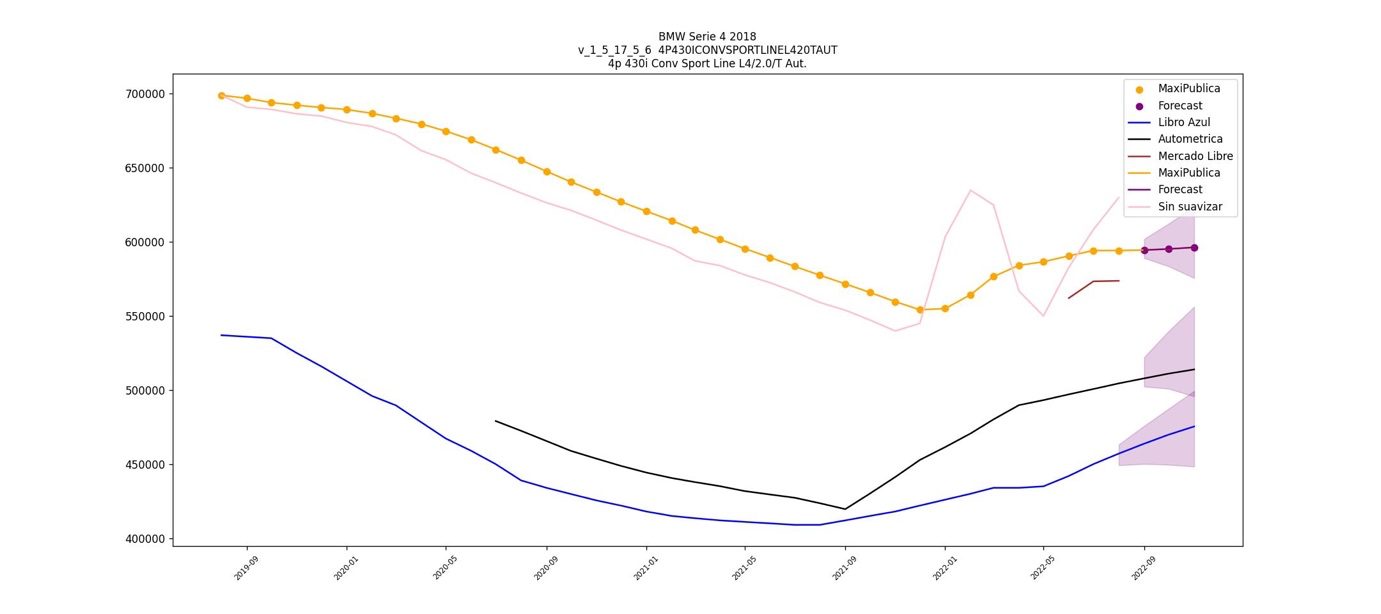

In [8]:
from IPython.display import Image
Image(filename='img_4.png',width=800, height=400)


<p>Also if there wasn't enough information to calculate the genreated price, the algorithm generates a price out of the informationm of his 
"brother" versions, if such data exists.</p>

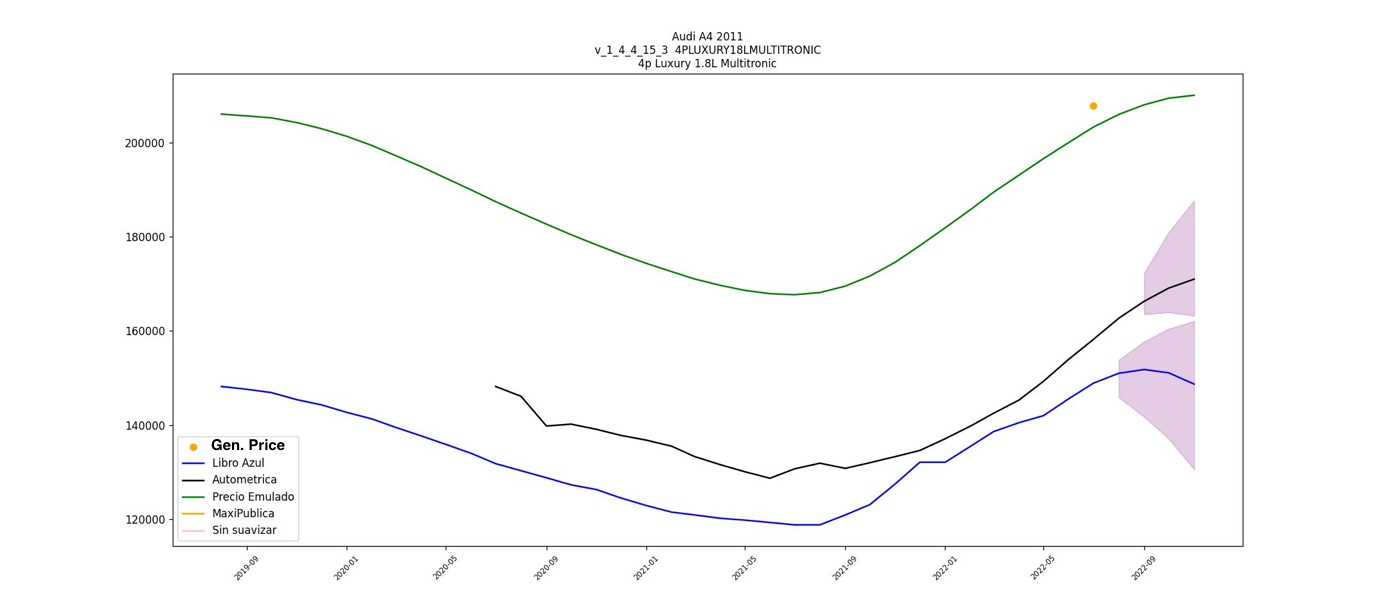

In [10]:
from IPython.display import Image
Image(filename='img_5.png',width=800, height=400)

In [ ]:
 
                    if precio_riesgoso == False:

                        # modded = original.rolling(5, min_periods=1, center=True, closed='both').mean()
                        # average = original
                        # average = average.rolling(5, min_periods=1, center=False, closed='both').mean()

                        average = average.astype({'price': 'int'})
                        average['price'] = average['price'].apply(lambda x: math.floor(x / 100) * 100)

                        promedio_anuncios_x = None
                        promedio_anuncios_y = None
                        x = [str(date).strip(' 00:00:00') for date in np.reshape(average.index, (-1))]
                        y = [int(precio) for precio in np.reshape(average.values, (-1))]
                        if sin_anuncios == False:
                            promedio_anuncios_x = x
                            promedio_anuncios_y = y

                            fechas = pd.date_range(start=allWeightX[0], end=allWeightX[-1], freq='MS')
                            # for z in range(0, len(allWeightX)):
                            #     ax.annotate(str(allWeightY[z]),
                            #                 (fechas[z], y[z]),
                            #                 arrowprops=dict(facecolor='red', arrowstyle='wedge'),
                            #                 xytext=(fechas[z], y[z] * 1.03), fontsize=14)

                        indexes = []
                        indexes1 = []
                        catRange = pd.date_range(start=x[0],
                                                 end=x[-1], freq='MS')
                        indexAnuncios = len(catRange.to_list())
                        indexes.append(indexAnuncios)
                        indexes1.append(catRange)
                        ebcFinal = np.nan
                        if ebcData:
                            ebcRange = pd.date_range(start=x_ebc[0],
                                                     end=x_ebc[-1], freq='MS')
                            ebcFinal = pd.Series(data=y_ebc, index=ebcRange)
                            indexEbc = len(ebcRange.to_list())
                            indexes.append(indexEbc)
                            indexes1.append(ebcRange)

                        gamFinal = np.nan
                        if gamData:
                            gamRange = pd.date_range(start=x_gam[0],
                                                     end=x_gam[-1], freq='MS')
                            gamFinal = pd.Series(data=y_gam, index=gamRange)
                            indexGam = len(gamRange.to_list())
                            indexes.append(indexGam)
                            indexes1.append(gamRange)

                        chosen_index = max(indexes)
                        definitiveDate = indexes1[indexes.index(chosen_index)]
                        info_agrupada = pd.DataFrame(data=[], index=definitiveDate)

                        emulation_average = pd.Series(index=[], data=[])
                        comparative = pd.DataFrame(index=catRange, data=[], columns=['ebc', 'gam'])

                        ad = pd.Series(data=y, index=catRange)
                        comparative['ads'] = ad
                        anuncios_list = comparative.ads.values
                        margen_de_utilidad = 0.15
                        emulated = False

                        if limit:

                            df = df['price'].groupby(df.index).mean()
                            df = pd.DataFrame(data=df.values, index=df.index.values, columns=['price'])
                            df.dateCreated = df.index
                            comparative['nuevos'] = pd.Series(data=df.price.values, index=df.index.values)
                            nuevos_lista = comparative.nuevos.values
                            precioNuevosDiff = numpy.subtract(anuncios_list, nuevos_lista)
                            if all(i <= 0 for i in precioNuevosDiff if str(i) != 'nan') == False:
                                rebazaNuevos = True

                        utilidadEbc = 0
                        utilidad = 0

                        if ebcData and flag == 'all':
                            limitNew = 0
                            xEbc = pd.date_range(start=x_ebc[0], end=x_ebc[-1], freq='MS')
                            ebc = pd.Series(data=y_ebc, index=xEbc)
                            comparative['ebc'] = ebc
                            ebc_list = comparative.ebc.values
                            ebcDifference = numpy.subtract(anuncios_list, ebc_list)

                            if np.isnan(ebc_list).all():
                                margen_de_utilidad = 0.15
                            else:
                                intersection = comparative[comparative.index >= xEbc[0]]
                                media_anuncios = statistics.mean(intersection.ads.values)
                                try:
                                    margen_inferior = statistics.mean([i for i in ebcDifference if i > 0])
                                except:
                                    margen_inferior = 0
                                # margen_de_utilidad = (-(100 / (100 /78)) + 100)/100
                                margen_de_utilidad = (-(
                                        100 / (intersection['ads'].mean() / intersection['ebc'].mean())) + 100) / 100
                                # margen_de_utilidad = (((media_anuncios / (media_anuncios - margen_inferior)) * 100) - 100) / 100
                                # print(margen_de_utilidad)
                                # print(intersection['ads'].mean())
                                # print(intersection['ebc'].mean())
                                # print( (-(100 / (intersection['ebc'].mean() / intersection['ads'].mean())) + 100)/100)

                            if limit:
                                newLimit = True

                                nuevos_ebc_comparative = pd.DataFrame(data=df.price.values,
                                                                      index=df.dateCreated.values,
                                                                      columns=['nuevos'])
                                if sam_data and samSwitch:
                                    nuevos_ebc_comparative['samDate'] = nuevos_ebc_comparative.index
                                    nuevos_ebc_comparative.at[ebc.index.values[0], 'nuevos'] = df.price.values[-1]
                                    nuevos_ebc_comparative['samDate'] = nuevos_ebc_comparative.index
                                    nuevos_ebc_comparative.drop([nuevos_ebc_comparative.index.values[0]], inplace=True)

                                # if sam_data and samSwitch:
                                #     sam_view = pd.DataFrame(data=nuevos_ebc_comparative.nuevos.values, index=nuevos_ebc_comparative.index.values, columns=['price'])
                                #     sam_view['dateCreated'] = sam_view.index
                                #     ax.scatter(ebc.index.values[0], sam_view['price'].values[-1], label='Precio Nuevo SAM Referencia', color='#17becf')

                                ebc = pd.Series(data=ebc.values, index=ebc.index)
                                nuevos_ebc_comparative['ebc'] = ebc
                                nuevos_ebc_comparative.dropna(axis=0, inplace=True)
                                if nuevos_ebc_comparative.empty == True:
                                    nuevos_ebc_comparative.at[ebc.index.values[0], 'nuevos'] = df.price.values[-1]
                                    nuevos_ebc_comparative.at[ebc.index.values[0], 'ebc'] = ebc.values[0]

                                newsList = nuevos_ebc_comparative.nuevos.values
                                ebcList = nuevos_ebc_comparative.ebc.values
                                precioNuevosDiff = numpy.subtract(newsList, ebcList)
                                # media_nuevos = statistics.mean(nuevos_ebc_comparative.nuevos.values)
                                # try:
                                #     margen_inferior = statistics.mean([i for i in precioNuevosDiff if i > 0])
                                # except:
                                #     margen_inferior = 0

                                # distancia_entre_ebc_nuevos = nuevos_ebc_comparative['nuevos'].values[0] - nuevos_ebc_comparative['ebc'].values[0]
                                # limitNew = (((nuevos_ebc_comparative['nuevos'].values[0] / (nuevos_ebc_comparative['nuevos'].values[0] - distancia_entre_ebc_nuevos)) * 100) - 100) / 100
                                # limitNew = (+(100 / (nuevos_ebc_comparative['ebc'].mean() / nuevos_ebc_comparative['nuevos'].mean())) + 100)/100
                                limitNew = (-(100 / (nuevos_ebc_comparative['nuevos'].mean() / nuevos_ebc_comparative[
                                    'ebc'].mean())) + 100) / 100

                                if str(limitNew) == 'nan':
                                    newLimit = False

                            utilidadEbc = margen_de_utilidad
                            utilidad = margen_de_utilidad * 100

                            forwardContained = len(pd.date_range(start=x[-1], end=x_ebc[-1], freq='MS').to_list()) - 1
                            # backwardContained = len(pd.date_range(start=x_ebc[0], end=x[0], freq='MS').to_list()) - 1
                            isContained = forwardContained >= 3

                            # arribaDeLaCurva = all(i > 0 for i in ebcDifference if str(i) != 'nan')
                            # longitudCorta = (len(y_ebc) / 2) >= len(y)
                            soloUnAnuncio = (len(y) == 1)
                            # how_many = (ebcDifference < 0).sum()

                            can_emulate = (sum(allWeightY) >= (len(allWeightY)) / 2) and (len(allWeightY) > 1)

                            if ((rebazaNuevos) or (soloUnAnuncio) or (isContained) or (not isForecast)):

                                if newLimit:
                                    if margen_de_utilidad > limitNew * 0.8 or margen_de_utilidad <= 0:
                                        margen_de_utilidad = limitNew / 2.5
                                utilidad = margen_de_utilidad * 100
                                if soloUnAnuncio:
                                    parents = cat.split('_')[0:5]
                                    parentId = ''
                                    for i in parents:
                                        parentId = parentId + i + '_'

                                    savedInfo = dev.anunciosEbcDiff_V2.find_one({'categoryId': parentId})
                                    # savedInfo = None
                                    if savedInfo != None:
                                        margen_de_utilidad = savedInfo['distanceFromEbc']
                                        if newLimit:
                                            if margen_de_utilidad > limitNew * 0.8 or margen_de_utilidad <= 0:
                                                margen_de_utilidad = limitNew / 2.5
                                        elif margen_de_utilidad <= 0:
                                            margen_de_utilidad = 0.15

                                    else:
                                        margen_de_utilidad = get_hermanos(cat=cat, sites=SITIOS, maxi=MAXI)
                                        if newLimit:
                                            if margen_de_utilidad > limitNew * 0.8 or margen_de_utilidad <= 0:
                                                margen_de_utilidad = limitNew / 2.5
                                        elif margen_de_utilidad <= 0:
                                            margen_de_utilidad = 0.15

                                emulation = pd.concat(emulation_frames, axis=0)
                                emulation['date'] = emulation.index
                                emulation['date'] = pd.to_datetime(emulation['date'], infer_datetime_format=True)
                                # Creación del promedio entre anuncios
                                emulation_average = emulation.groupby('date').agg({'price': pd.Series.mean})
                                emulation_average['price'] = emulation_average['price'].apply(
                                    lambda x: x * (1 + margen_de_utilidad))
                                emulation_average = emulation_average.rolling(5, min_periods=1, center=True,
                                                                              closed='both').mean()
                                emulation_average = emulation_average.rolling(3, min_periods=1, center=True,
                                                                              closed='both').mean()
                                emulation_average = emulation_average.astype({'price': 'int'})
                                emulated = True

                        if gamData and flag == 'all':
                            limitNewGam = 0
                            xGam = pd.date_range(start=x_gam[0], end=x_gam[-1], freq='MS')

                            if emulation_average.empty == True:
                                gam = pd.Series(data=y_gam, index=xGam)
                                comparative['gam'] = gam
                                gam_list = comparative.gam.values
                                gamDifference = numpy.subtract(anuncios_list, gam_list)
                                if not ebcData:
                                    if np.isnan(gam_list).all() or (
                                            all(i < 0 for i in gamDifference if str(i) != 'nan') == True):
                                        margen_de_utilidad = 0.15
                                    else:
                                        intersection = comparative[comparative.index > xGam[0]]
                                        media_anuncios = statistics.mean(intersection.ads.values)
                                        try:
                                            margen_inferior = statistics.mean([i for i in gamDifference if i > 0])
                                        except:
                                            margen_inferior = 0
                                            margen_de_utilidad = (-(
                                                    100 / (
                                                    intersection['ads'].mean() / intersection[
                                                'gam'].mean())) + 100) / 100
                                else:
                                    utilidadGam = utilidadEbc
                                    margen_de_utilidad = utilidadGam

                                if limit:
                                    newLimit = True
                                    nuevos_gam_comparative = pd.DataFrame(data=df.price.values,
                                                                          index=df.dateCreated.values,
                                                                          columns=['nuevos'])
                                    gam = pd.Series(data=gam.values, index=gam.index)
                                    nuevos_gam_comparative['gam'] = gam
                                    newsList = nuevos_gam_comparative.nuevos.values
                                    gamList = nuevos_gam_comparative.gam.values
                                    # media_nuevos = statistics.mean(nuevos_gam_comparative.nuevos.values)
                                    precioNuevosDiff = numpy.subtract(newsList, gamList)

                                    # try:
                                    #     margen_inferior = statistics.mean([i for i in precioNuevosDiff if i > 0])
                                    # except:
                                    #     margen_inferior = 0
                                    limitNewGam = (-(
                                                100 / (nuevos_gam_comparative['nuevos'].mean() / nuevos_gam_comparative[
                                            'gam'].mean())) + 100) / 100
                                    if str(limitNewGam) == 'nan':
                                        newLimit = False

                                utilidad = margen_de_utilidad * 100
                                forwardContained = len(
                                    pd.date_range(start=x[-1], end=x_gam[-1], freq='MS').to_list()) - 1
                                # backwardContained = len(pd.date_range(start=x_gam[0], end=x[0], freq='MS').to_list()) - 1
                                # how_many = (gamDifference < 0).sum()
                                # arribaDeLaCurva = all(i > 0 for i in gamDifference if str(i) != 'nan')
                                isContained = forwardContained >= 3
                                # longitudCorta = (len(y_gam) / 2) >= len(y)
                                soloUnAnuncio = (len(y) == 1)
                                can_emulate = (sum(allWeightY) >= (len(allWeightY)) / 2) and (len(allWeightY) > 1)

                                if ((rebazaNuevos) or (soloUnAnuncio) or (isContained) or (not isForecast)):
                                    if newLimit:
                                        if margen_de_utilidad > limitNewGam * 0.75:
                                            margen_de_utilidad = limitNewGam / 2.5
                                    utilidad = margen_de_utilidad * 100

                                    if soloUnAnuncio:
                                        parents = cat.split('_')[0:5]
                                        parentId = ''
                                        for i in parents:
                                            parentId = parentId + i + '_'

                                        savedInfo = dev.anunciosEbcDiff_V2.find_one({'categoryId': parentId})
                                        if savedInfo != None:
                                            margen_de_utilidad = savedInfo['distanceFromEbc']
                                            if newLimit:
                                                if margen_de_utilidad > limitNewGam * 0.8 or margen_de_utilidad == 0:
                                                    margen_de_utilidad = limitNewGam / 2.5
                                            elif margen_de_utilidad == 0:
                                                margen_de_utilidad = 0.15


                                        else:
                                            margen_de_utilidad = get_hermanos(cat=cat, sites=SITIOS, maxi=MAXI)
                                            if newLimit:
                                                if margen_de_utilidad > limitNewGam * 0.8 or margen_de_utilidad == 0:
                                                    margen_de_utilidad = limitNewGam / 2.5
                                            elif margen_de_utilidad == 0:
                                                margen_de_utilidad = 0.15

                                    emulation = pd.DataFrame(data=gam.values, index=gam.index.values, columns=['price'])
                                    emulation['date'] = emulation.index
                                    # Creación del promedio entre anuncios
                                    emulation_average = emulation.groupby('date').agg({'price': pd.Series.mean})
                                    emulation_average['price'] = emulation_average['price'].apply(
                                        lambda x: x * (1 + margen_de_utilidad))
                                    emulation_average = emulation_average.rolling(5, min_periods=1, center=True,
                                                                                  closed='both').mean()
                                    emulation_average = emulation_average.rolling(3, min_periods=1, center=True,
                                                                                  closed='both').mean()
                                    emulated = True

                        if df.empty == False:
                            df.dateCreated = pd.to_datetime(df.dateCreated, infer_datetime_format=True)
                            nuevos = pd.Series(index=df.dateCreated, data=df.price.values)
                            nuevos.dropna(axis=0, inplace=True)
                            nuevos = nuevos.reindex(
                                pd.date_range(start=nuevos.index.values[0], end=nuevos.index.values[-1], freq='MS'),
                                fill_value=np.nan)

                        # En este punto ya se cuentan con los precios de ENTERPRISE
                        else:
                            nuevos = np.nan
                        if emulation_average.empty == False:
                            utilidad = pd.Series(index=emulation_average.index, data=utilidad)

                        if mlmData:
                            mercadoLibre = pd.Series(data=mercadoLibre.price.values, index=mercadoLibre.index)
                            xMlm = [str(date).strip(' 00:00:00') for date in np.reshape(mercadoLibre.index, (-1))]
                            yMlm = [int(precio) for precio in np.reshape(mercadoLibre.values, (-1))]

                        muestreo = pd.DataFrame(data=allWeightY, index=allWeightX, columns=['Muestra'])
                        muestreo.index = pd.to_datetime(muestreo.index, infer_datetime_format=True)
                        try:
                            previous_month = dt(today.year, today.month - 1, 1)
                        except:
                            previous_month = dt(today.year - 1, 12, 1)

                        actual_month = dt(today.year, today.month, 1)
                        muestreo_ultimo_mes = muestreo[muestreo.index == previous_month]

                        if sam_data:
                            sam_info = pd.Series(data=sam_info.price.values, index=sam_info.index)
                        else:
                            sam_info = pd.Series(data=[], index=[])

                        # fig, ax = plt.subplots(figsize=(1 8, 8), dpi=120)

                        info_agrupada['id'] = cat
                        info_agrupada['Marca'] = brand
                        info_agrupada['Modelo'] = model
                        info_agrupada['Año'] = year
                        info_agrupada['Versión'] = trim
                        info_agrupada['External Id'] = extId
                        info_agrupada['Libro Azul'] = ebcFinal
                        info_agrupada['Autometrica'] = gamFinal
                        info_agrupada['ENTERPRISE (Anuncios)'] = ad
                        info_agrupada['Muestreo Histórico'] = muestreo
                        info_agrupada['Muestreo Último Mes'] = muestreo_ultimo_mes
                        info_agrupada['Muestreo Total'] = np.nan
                        info_agrupada.at[muestreo.index[-1], 'Muestreo Total'] = sum(allWeightY)
                        info_agrupada['ENTERPRISE (Emulados)'] = emulation_average
                        info_agrupada['Precio Nuevo'] = nuevos
                        info_agrupada['Precio SAM'] = sam_info
                        info_agrupada['Diferencia'] = utilidad
                        info_agrupada['Mercado Libre'] = mercadoLibre
                        info_agrupada['Upper'] = upper
                        info_agrupada['forecast'] = forecast
                        info_agrupada['Lower'] = lower

                        if sam_data and info_agrupada['Precio SAM'].values == []:
                            sam = pd.DataFrame(data=sam_info.price.values, index=sam_info.index, columns=['SAM price'])
                            info_agrupada = pd.concat([sam, info_agrupada])

                        try:
                            model = str(model)
                        except:
                            model = ''
                        try:
                            brand = str(brand)
                        except:
                            brand = ''
                        try:
                            year = str(year)
                        except:
                            year = ''
                        try:
                            trim = str(trim)
                        except:
                            trim = ''

                        positioning_y = 0.48
                        positioning_x = 1.05
                        # plt.title(' ', fontsize=14)
                        # plt.suptitle(brand + ' ' + model + ' ' + str(year) + '\n', fontsize=17)
                        # ax.text(positioning_y, positioning_x, cat + '\n' + trim,
                        #         horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12)

                        # plt.xticks(rotation=45, fontsize=10)

                        # ax.scatter(df.index, df.price, label='',
                        #            color='red')

                        # if not sin_anuncios:
                        # ax.scatter(info_agrupada.index, info_agrupada['ENTERPRISE (Anuncios)'], label='ENTERPRISE',
                        #            color='orange')

                        # if isForecast:
                        # ax.scatter(forecast.index, forecast.values, label='ENTERPRISE Forecast',
                        #            color='purple', marker='x')

                        # if info_agrupada['Precio Nuevo'].isnull().all() == False:
                        # ax.plot(info_agrupada.index, info_agrupada['Precio Nuevo'], label='Precio Nuevo', color='red')
                        # ax.scatter(info_agrupada.index, info_agrupada['Precio Nuevo'], color='red', marker='d')

                        # if info_agrupada['Libro Azul'].isnull().all() == False:
                        #     ax.plot(info_agrupada.index, info_agrupada['Libro Azul'], label='Libro Azul', color='blue')
                        #     ax.scatter(info_agrupada.index[-3:], info_agrupada['Libro Azul'].values[-3:],
                        #                label='Libro Azul Forecast',
                        #                color='blue', marker='v')
                        # if info_agrupada['Autometrica'].isnull().all() == False:
                        #     ax.plot(info_agrupada.index, info_agrupada.Autometrica, label='Autometrica', color='black')
                        #     ax.scatter(info_agrupada.index.values[-3:], info_agrupada.Autometrica.values[-3:],
                        #                label='Autometrica Forecast', color='black', marker='^')

                        # if mlmData:
                        #     ax.plot(info_agrupada.index, info_agrupada['Mercado Libre'], color='brown')
                        #     ax.scatter(info_agrupada.index, info_agrupada['Mercado Libre'], label='Mercado Libre',
                        #                color='brown',
                        #                marker='s')

                        # ax.plot(info_agrupada.index, info_agrupada['ENTERPRISE (Anuncios)'], label='ENTERPRISE',
                        #         color='orange')
                        # ax.axvline(actual_month, color='gray', linestyle='--')

                        # if isForecast:
                        #     ax.plot(forecast.index, forecast.values, color='purple')
                        # ax.plot(original.index, original['price'], label='Sin suavizar', color='pink')

                        if not df.empty:
                            try:
                                nuevosX = [str(date).strip(' 00:00:00') for date in np.reshape(df.index, (-1))]
                                nuevosY = [int(precio) for precio in np.reshape(df.values, (-1))]
                            except:
                                pass

                        if not sam_info.empty:
                            try:
                                samNuevosX = [str(date).strip(' 00:00:00') for date in np.reshape(sam_info.index, (-1))]
                                samNuevosY = [int(precio) for precio in np.reshape(sam_info.values, (-1))]
                            except:
                                pass

                        forecastX = []
                        forecastY = []
                        if isForecast:
                            forecastX = [str(date).strip(' 00:00:00') for date in np.reshape(forecast.index, (-1))]
                            forecastY = [int(precio) for precio in np.reshape(forecast.values, (-1))]
                        try:
                            average_distance_date_info = dt(today.year, today.month - 5, 1)
                        except:
                            average_distance_date_info = dt(today.year - 1, 12 + (today.month - 5), 1)

                        actualDate = dt(today.year, today.month, 1)

                        diferencia = info_agrupada[info_agrupada.index >= average_distance_date_info]
                        diferencia = diferencia[diferencia.index <= actualDate]
                        infos_for_comparative = ['ENTERPRISE (Emulados)', 'Libro Azul', 'Autometrica', 'Mercado Libre']
                        if diferencia['ENTERPRISE (Emulados)'].isnull().all() == True:
                            infos_for_comparative[0] = 'ENTERPRISE (Anuncios)'

                        diferencia.drop(labels=['Upper', 'Lower', 'forecast', 'Diferencia', 'Precio Nuevo'],
                                        axis=1, inplace=True)

                        for fuente in infos_for_comparative:
                            if diferencia[fuente].isnull().all() == True:
                                diferencia.drop(labels=[fuente], axis=1, inplace=True)
                                infos_for_comparative.pop(infos_for_comparative.index(fuente))
                                info_agrupada['vs ' + fuente] = np.nan

                        promedios = []
                        distancias_de_fuentes = {f: '' for f in infos_for_comparative[1:]}
                        for fuente in infos_for_comparative[1:]:
                            promedio = diferencia[fuente].mean()
                            promedios.append(promedio)
                            ceil = diferencia[infos_for_comparative[0]].mean()
                            floor = promedio
                            distance = ceil - floor
                            porcentaje = (100 / (ceil / distance))
                            distancias_de_fuentes[fuente] = round(porcentaje, 2)
                            info_agrupada['vs ' + fuente] = round(porcentaje, 2)
                        #     info_agrupada['vs ' + fuente + f' {str(actualDate).strip(" 00:00:00")}'] = round(porcentaje, 2)

                        if gamData and 'Autometrica' in distancias_de_fuentes.keys() \
                                and distancias_de_fuentes['Autometrica'] <= 0 and emulated and len(x_gam) > len(
                            x) and len(x_gam) > 6:

                            # https://drive.google.com/file/d/1PpwynPiAtcFB-ZSaPptEHQjVyhAjIAUU/view CASO QUE EXPLICA LAS CONDICIONES
                            gam = pd.DataFrame(data=gam.values, index=gam.index, columns=['price'])
                            emulation_average['price'] = gam['price'].apply(lambda x: x * (1 + margen_de_utilidad))
                            info_agrupada['ENTERPRISE (Emulados)'] = emulation_average

                            try:
                                average_distance_date_info = dt(today.year, today.month - 5, 1)
                            except:
                                average_distance_date_info = dt(today.year - 1, 12 + (today.month - 5), 1)

                            actualDate = dt(today.year, today.month, 1)
                            # print(info_agrupada)
                            diferencia = info_agrupada[info_agrupada.index >= average_distance_date_info]
                            diferencia = diferencia[diferencia.index <= actualDate]
                            infos_for_comparative = ['ENTERPRISE (Emulados)', 'Libro Azul', 'Autometrica',
                                                     'Mercado Libre']
                            if diferencia['ENTERPRISE (Emulados)'].isnull().all() == True:
                                infos_for_comparative[0] = 'ENTERPRISE (Anuncios)'

                            diferencia.drop(labels=['Upper', 'Lower', 'forecast', 'Diferencia', 'Precio Nuevo'],
                                            axis=1, inplace=True)

                            for fuente in infos_for_comparative:
                                if diferencia[fuente].isnull().all() == True:
                                    diferencia.drop(labels=[fuente], axis=1, inplace=True)
                                    infos_for_comparative.pop(infos_for_comparative.index(fuente))
                                    info_agrupada['vs ' + fuente] = np.nan

                            promedios = []
                            distancias_de_fuentes = {f: '' for f in infos_for_comparative[1:]}
                            for fuente in infos_for_comparative[1:]:
                                promedio = diferencia[fuente].mean()
                                promedios.append(promedio)
                                ceil = diferencia[infos_for_comparative[0]].mean()
                                floor = promedio
                                distance = ceil - floor
                                porcentaje = (100 / (ceil / distance))
                                distancias_de_fuentes[fuente] = round(porcentaje, 2)
                                info_agrupada['vs ' + fuente] = round(porcentaje, 2)

                        if info_agrupada['ENTERPRISE (Emulados)'].isnull().all() == False:
                            info_agrupada['ENTERPRISE (Emulados)'] = emulation_average
                            # ax.plot(info_agrupada.index, info_agrupada['ENTERPRISE (Emulados)'], label='Precio Emulado',
                            #         color='green')
                            # ax.scatter(info_agrupada.index.values[-3:], info_agrupada['ENTERPRISE (Emulados)'].values[-3:],
                            #            label='Precio Emulado Forecast', color='green', marker='x')

                        positioning_y = 0.07
                        positioning_x = 1.04
                        for key in distancias_de_fuentes.keys():

                            if key == 'Mercado Libre' and mlmData == False:
                                continue
                            if key == 'Autometrica' and gamData == False:
                                continue
                            if key == 'Libro Azul' and ebcData == False:
                                continue
                            else:
                                if info_agrupada.loc[info_agrupada.index == actual_month][key].values != []:
                                    precio = info_agrupada.loc[info_agrupada.index == actual_month][key].values[-1]
                                else:
                                    precio = info_agrupada[key].values[-1]

                                if str(precio) == 'nan':
                                    precio = info_agrupada[key].dropna(axis=0).values[-1]

                                texto = str(key) + ': ' + str(distancias_de_fuentes[key]) + ',   Precio: $' + str(
                                    f'{precio:,}')
                                # ax.text(positioning_y, positioning_x, texto,
                                #         horizontalalignment='center',
                                #         verticalalignment='center', transform=ax.transAxes)
                                positioning_x += 0.03

                        positioning_y = 0.80

                        positioning_x = 1.04

                        if sam_data:
                            sam_price = int(sam_info.values[-1])
                            sam_price_formatted = f'{sam_price:,}'

                            # sam_price_formatted = int(sam_price_formatted)

                            # ax.text(positioning_y, positioning_x, f'Precio Auto Nuevo: ${sam_price_formatted}',
                            #         verticalalignment='center', transform=ax.transAxes, color='black', fontsize=12)

                        positioning_x = 1.07
                        total_anuncios = f'{sum(allWeightY):,}'
                        # if sin_anuncios:
                        # ax.text(positioning_y, positioning_x, f'Tamaño total de muestra : {0}',
                        #         verticalalignment='center', transform=ax.transAxes, color='black', fontsize=12)
                        # else:
                        # ax.text(positioning_y, positioning_x, f'Tamaño total de muestra : {total_anuncios}',
                        #         verticalalignment='center', transform=ax.transAxes, color='black', fontsize=12)

                        # positioning_x = 1.1
                        # if sin_anuncios:
                        # ax.text(positioning_y, positioning_x, f'Muestra último mes: {0}',
                        #         verticalalignment='center', transform=ax.transAxes, color='black', fontsize=12)
                        # else:
                        #     ax.text(positioning_y, positioning_x, f'Muestra último mes: {allWeightY[-1]}',
                        #             verticalalignment='center', transform=ax.transAxes, color='black', fontsize=12)

                        if emulated:
                            emulation_average.dropna(inplace=True, axis=0)
                            info_agrupada['ENTERPRISE'] = emulation_average
                            x = [str(date).strip(' 00:00:00') for date in np.reshape(emulation_average.index, (-1))]
                            y = [int(precio) for precio in np.reshape(emulation_average.values, (-1))]


                        else:
                            info_agrupada['ENTERPRISE'] = ad

                        # if isForecast or emulated:
                        #     positioning_y = 0.42
                        #     positioning_x = 0.97
                        #     price = 0
                        #
                        #     try:
                        #         price = f'{y[-4]:,}'
                        #     except:
                        #         try:
                        #             price = f'{y[-1]:,}'
                        #         except:
                        #             continue

                        # ax.text(positioning_y, positioning_x, f'ENTERPRISE : {price}',
                        #         verticalalignment='center', transform=ax.transAxes, color='black', fontsize=12)

                        # else:
                        #     positioning_y = 0.42
                        #     positioning_x = 0.97
                        #     price = f'{y[-1]:,}'
                        #
                        #     ax.text(positioning_y, positioning_x, f'ENTERPRISE:{price}',
                        #             verticalalignment='center', transform=ax.transAxes, color='black', fontsize=12)

                        # positioning_y = 0.44
                        # positioning_x = 0.91

                        # if flag == 'private_seller' or flag == 'car_dealer':
                        #     ax.text(positioning_y, positioning_x, f'Type: {flag}',
                        #             verticalalignment='center', transform=ax.transAxes, color='black', fontsize=12)

                        # plt.legend()
                        # plt.savefig(f'{cat}.jpg')
                        # id, link = upload.upload_image(f'{cat}.jpg')
                        link = f'https://api.ENTERPRISE.com/v3/price_chart/maxiPrice?categoryId={cat}&type={flag}&graphic=prices'
                        # os.remove(f'{cat}.jpg')

                        # reporte = pd.concat([reporte, info_agrupada])
                        if sin_anuncios:
                            allWeightY = [0]
                            weightSites = [0]
                        today = dt.today()
                        EXECUTION_DATE = dt(today.year, today.month, today.day)

                        differences = {i: distancias_de_fuentes[i] for i in distancias_de_fuentes.keys()}
                        filter = {'categoryId': cat, 'type': flag}
                        newValues = {"$set": {"categoryId": category,
                                              "brand": brand,
                                              "model": model,
                                              "year": int(float(year)),
                                              "trim": trim,
                                              "externalId": extId,
                                              "gamCategoryId": categGam,
                                              "mxpCategoryId": categMxp,
                                              "mlmId": mlmId,
                                              "samId": samId,
                                              "adsAverage": {
                                                  "suavizado": {"x": x, "y": y},
                                                  "noSuavizado": {"x": xRaw, "y": yRaw},
                                                  "informaciónOriginal": {"x": promedio_anuncios_x,
                                                                          "y": promedio_anuncios_y}
                                              },
                                              "forecastPrices": {"x": forecastX, "y": forecastY, 'upper': upperY,
                                                                 'lower': lowerY},
                                              "forecastPricesGam": {"x": x_gam_forecast, "y": y_gam_forecast,
                                                                    'upper': upperGam,
                                                                    'lower': lowerGam},
                                              "forecastPricesEbc": {"x": x_ebc_forecast, "y": y_ebc_forecast,
                                                                    'upper': upperEbc,
                                                                    'lower': lowerEbc},
                                              "distances": differences,
                                              "comparativas": distancias_de_fuentes,

                                              "sources": {
                                                  "gdp_uniqueAds_2": {"x": x_anuncios, "y": y_anuncios},
                                                  "gdp_unique_ads": {"x": x_maxi, "y": y_maxi},
                                                  "ebc": {"x": x_ebc, "y": y_ebc},
                                                  "ebcForecast": {"x": x_ebc_forecast, "y": y_ebc_forecast},
                                                  "gam": {"x": x_gam, "y": y_gam},
                                                  "gamForecast": {"x": x_gam_forecast, "y": y_gam_forecast},
                                                  "mlm": {"x": xMlm, "y": yMlm},
                                                  "newVersionInfo": {"x": nuevosX, "y": nuevosY},
                                                  "samNewVersionInfo": {"x": samNuevosX, "y": samNuevosY},
                                              },

                                              "historicWeight": {
                                                  "mlm": {"x": datesSites, "y": mlmWeight},
                                                  "smm": {"x": datesSites, "y": smmWeight},
                                                  "sam": {"x": datesSites, "y": samWeight},
                                                  "ads": {"x": datesSites, "y": weightSites},
                                                  "maxi": {"x": datesENTERPRISE, "y": weightENTERPRISE},
                                                  "total": {"x": allWeightX, "y": allWeightY}},

                                              "totalWeight": {
                                                  "weightSites": int(weightAnuncios),
                                                  "weightMaxi": int(weightMaxi),
                                                  "weightSitesEliminated": int(originalWeightAnuncios - weightAnuncios),
                                                  "weightMaxiEliminated": int(originalWeightMaxi - weightMaxi)},

                                              "siteAdsData": siteAdsData,
                                              "adsMxMxpData": adsMxMxpData,
                                              "ebcData": ebcData,
                                              "gamData": gamData,
                                              "samData": sam_data,
                                              "mlmData": mlmData,
                                              "ebcNewData": ebcNewData,
                                              "isForecast": isForecast,
                                              "tpv": tpv,
                                              "sitesTpv": {'x': sitesTpvX, 'y': sitesTpvY},
                                              "maxiTpv": {'x': adsTpvX, 'y': adsTpvY},
                                              "sale_time": {'x': tpvX, 'y': tpvY},
                                              "sales": {'x': salesX, 'y': salesY},
                                              "price_hist": {'x': price_hist_x, 'y': price_hist_y},
                                              "odometer_hist": {'x': odometer_hist_x, 'y': odometer_hist_y},
                                              "country": country,
                                              "weight": sum(allWeightY),
                                              # Entradas comentadas tempralmente
                                              "statesPrices": state_prices,
                                              # diccionario de arreglos filtrados por cada estado
                                              "economicZonesPrices": economic_zone_prices,
                                              # diccionario de arreglos X y Y filtrados por cada zona económica
                                              "statesExternalAds": externalState,
                                              "statesMaxiAds": MPstate,
                                              "emulated": emulated,
                                              'error': False,
                                              'noAds': sin_anuncios,
                                              'type': flag,
                                              'link': link,
                                              'dateProcess': EXECUTION_DATE
                                              # 'errorCode': 'TESTING USD'
                                              }}



<p>Up to this point the data is saved in a database. The algorithm has many more things that could take a very long and detailed explanation, but for a practical demo is not necessary to cover very technical details</p>

<p>If you want to see a flux diagram, i share you a link for more detail : " https://miro.com/app/board/uXjVNyXeGDE=/ "</p>



In [ ]:

                        # plt.legend()
                        # plt.show()
                        # plt.close()
                        # plt.close(fig)

                        newValues = dict(newValues)
                        sale = newValues['$set']['sales']
                        sale_time = newValues['$set']['sale_time']

                        if sale['x'] != None:
                            # fig, ax = plt.subplots(figsize=(18, 8), dpi=120)
                            sales = pd.Series(data=sale["y"], index=sale["x"])
                            sales_times = pd.Series(data=sale_time['y'], index=sale_time['x'])

                            # plt.set_loglevel('WARNING')

                            # positioning_y = 0.48
                            # positioning_x = 1.05
                            # plt.title('   ', fontsize=14)
                            # plt.suptitle('Tiempos de venta y ventas por mes' + '\n', fontsize=17)
                            # ax.text(positioning_y, positioning_x, cat + '\n',
                            #         horizontalalignment='center', verticalalignment='center', transform=ax.transAxes,
                            #         fontsize=14)
                            #
                            # plt.bar(sales.index.values, sales.values, color='red', label='Autos vendidos')
                            # plt.bar(sales_times.index.values, sales_times.values, color='orange', alpha=0.7, width=0.5,
                            #         label='Tiempo de venta')
                            # plt.xticks(rotation=45, fontsize=10)
                            #
                            # plt.legend()

                            # plt.savefig(f'{cat}.jpg')
                            # id, link = upload.upload_image(f'{cat}.jpg')
                            # os.remove(f'{cat}.jpg')
                            #
                            # plt.show()
                            # plt.close()
                            # plt.close(fig)
                            newValues['$set'][
                                'linkSales'] = f'https://api.ENTERPRISE.com/v3/price_chart/maxiPrice?categoryId={cat}&type={flag}&graphic=salesTimes'
                            newValues['$set'][
                                'linkSales4M'] = f'https://api.ENTERPRISE.com/v3/price_chart/maxiPrice?categoryId={cat}&type={flag}&graphic=salesTimes4M'

                            # sections = [1, 0.75, 0.50, 0.25, 0.01]
                            sales.index = pd.date_range(start=sales.index.values[0], end=sales.index.values[-1],
                                                        freq='MS')
                            sales_times.index = pd.date_range(start=sales_times.index.values[0],
                                                              end=sales_times.index.values[-1], freq='MS')

                            sales_times = sales_times.groupby(pd.Grouper(freq='4MS')).aggregate(numpy.mean)
                            sales = sales.groupby(pd.Grouper(freq='4MS')).aggregate(numpy.sum)

                            sales_cuatrimestreX = [str(date).strip(' 00:00:00') for date in
                                                   np.reshape(sales.index, (-1))]
                            sales_cuatrimestreY = [int(precio) for precio in np.reshape(sales.values, (-1))]

                            salesTimes_cuatrimestreX = [str(date).strip(' 00:00:00') for date in
                                                        np.reshape(sales_times.index, (-1))]
                            salesTimes_cuatrimestreY = [int(precio) for precio in np.reshape(sales_times.values, (-1))]
                            newValues['$set']['sales_4M_period'] = {'x': sales_cuatrimestreX, 'y': sales_cuatrimestreY}
                            newValues['$set']['sale_time_4M_period'] = {'x': salesTimes_cuatrimestreX,
                                                                        'y': salesTimes_cuatrimestreY}
                            newValues['$set']['hasSales'] = True

                        else:
                            newValues['$set']['sales_4M_period'] = {'x': None, 'y': None}
                            newValues['$set']['sale_time_4M_period'] = {'x': None, 'y': None}
                            newValues['$set']['linkSales'] = None
                            newValues['$set']['hasSales'] = False
                        # print('actualizado 1')
                        dev.ENTERPRISEAdsMeanEmulationV6.update_one(filter, newValues, upsert=True)
                    else:
                        # plt.close()
                        # plt.close(fig)
                        filter = {'categoryId': cat, 'type': flag}
                        newValues = {'$set': {'categoryId': cat, 'notProcessed': True, 'type': flag}}
                        dev.ENTERPRISEAdsMeanEmulationV6.delete_one(filter)
                        dev.ENTERPRISEAdsMeanEmulationV6.update_one(filter, newValues, upsert=True)
                        # print('actualizado 2')
                        continue
                else:
                    # plt.close()
                    # plt.close(fig)
                    filter = {'categoryId': cat, 'type': flag}
                    newValues = {'$set': {'categoryId': cat, 'notProcessed': True, 'type': flag}}
                    dev.ENTERPRISEAdsMeanEmulationV6.delete_one(filter)
                    dev.ENTERPRISEAdsMeanEmulationV6.update_one(filter, newValues, upsert=True)
                    # print('actualizado 3')
                    continue

            except Exception as e:
                print(cat)
                print(traceback.format_exc())
                print(e)
                # print('actualizado 4')
                filter = {'categoryId': cat, 'type': flag}
                newValues = {'$set': {'categoryId': cat, 'errorCode': str(e), 'error': True, 'type': flag}}
                dev.ENTERPRISEAdsMeanEmulationV6.update_one(filter, newValues, upsert=True)
                continue


oCatInfo = pd.read_csv('oCatMx.csv')
ebc = pd.read_csv('./ebc_prices.csv')
gam = pd.read_csv('./gam_precios.csv')
mlm = pd.read_csv('./mlm_precios.csv')
sam = pd.read_csv('./sam_precios.csv')
precio_nuevos = pd.read_csv('./new_prices.csv')
sites = pd.read_csv('./siteAds.csv')
maxi = pd.read_csv('./maxiAds.csv')

sites['lastProcessed'] = pd.to_datetime(sites['lastProcessed'], infer_datetime_format=True)
maxi['lastProcessed'] = pd.to_datetime(maxi['lastProcessed'], infer_datetime_format=True)
ebc['dateCreated'] = pd.to_datetime(ebc['dateCreated'], infer_datetime_format=True)
gam['dateCreated'] = pd.to_datetime(gam['dateCreated'], infer_datetime_format=True)
sam['dateCreated'] = pd.to_datetime(sam['dateCreated'], infer_datetime_format=True)
mlm['date'] = pd.to_datetime(mlm['date'], infer_datetime_format=True)

precio_nuevos['dateCreated'] = pd.to_datetime(precio_nuevos['dateCreated'], infer_datetime_format=True)

sites.index = sites['categoryId']
maxi.index = maxi['categoryId']
ebc.index = ebc['dateCreated']
gam.index = gam['dateCreated']
sam.index = pd.to_datetime(sam['dateCreated'], infer_datetime_format=True)
mlm.index = mlm['date']
precio_nuevos.index = pd.to_datetime(precio_nuevos['dateCreated'], infer_datetime_format=True)

sites['lastProcessed'] = sites['lastProcessed'].dt.strftime('%Y-%m-01')
maxi['lastProcessed'] = maxi['lastProcessed'].dt.strftime('%Y-%m-01')

sites.drop(columns=['Unnamed: 0', '_id'], inplace=True)
maxi.drop(columns=['Unnamed: 0', '_id'], inplace=True)
ebc.drop(columns=['Unnamed: 0', '_id'], inplace=True)
gam.drop(columns=['Unnamed: 0', '_id'], inplace=True)
sam.drop(columns=['Unnamed: 0', '_id'], inplace=True)
mlm.drop(columns=['Unnamed: 0', '_id'], inplace=True)
oCatInfo.drop(columns=['0'], inplace=True)
precio_nuevos.drop(columns=['Unnamed: 0', '_id'], inplace=True)

# correciones = pd.read_csv('correcciones.csv')
# cats = list(correciones['categoryId'].values)
# emuladas = pd.read_csv('emuladas.csv')
# usd_act = pd.read_csv('Reporte de categorías con precios en USD.csv')
# errores = pd.read_csv('errores.csv')
# precios_bajos = pd.read_csv('precios bajos.csv')
# precios_altos = pd.read_csv('precios altos.csv')
# precios_cortos = pd.read_csv('precios cortos.csv')
# emblemas = pd.read_csv('REPORTE_PRECIOS_KIA.csv')
#
# emuladas = list(emuladas['categoryId'].values )
# usd =  list(usd_act['categoryId'].values)
# errores =  list(errores['categoryId'].drop_duplicates().values)
# bajos =  list(precios_bajos['categoryId'].drop_duplicates().values)
# altos =  list(precios_altos['categoryId'].drop_duplicates().values)
# cortos =  list(precios_cortos['categoryId'].drop_duplicates().values)
# emblemas = list(emblemas['categoryId'].values )
# cats = emblemas

# cats = [i for i in cats if i not in bajos]
# cats = [i for i in cats if i not in altos]
# cats = [i for i in cats if i not in cortos]

categorias = pd.DataFrame(data=oCatInfo['categoryId'].values, columns=['categoryId'])

categorias = categorias.categoryId.drop_duplicates()
cats = categorias.dropna().values
print(len(cats))
# marcas = pd.DataFrame(data=cats, columns=['categoryId'])
# kia = marcas.loc[lambda x: x['categoryId'].str.contains('v_1_29', regex=True, na=False)]
# chevrolet = marcas.loc[lambda x: x['categoryId'].str.contains('v_1_11', regex=True, na=False)]
# nissan = marcas.loc[lambda x: x['categoryId'].str.contains('v_1_41', regex=True, na=False)]
# marcas = pd.concat([kia, nissan, chevrolet])
# marcas = marcas['categoryId'].values


cats = np.array_split(cats, 16)
cats = [list(i) for i in cats]
#
# 12500


if __name__ == '__main__':
    print('Multiprocessing iniciado')
    #     # print('All')
    flag = ['all', 'car_dealer', 'private_seller']
    # #     # a = create_price_a(['v_1_11_6_11_10'], ebc, gam, mlm, sam, sites, maxi, precio_nuevos, oCatInfo, flag),
    #     b = create_price_a(['v_1_39_4_5_10'], ebc, gam, mlm, sam, sites, maxi, precio_nuevos, oCatInfo, flag)
    #     c = create_price_a(['v_1_39_4_5_4'], ebc, gam, mlm, sam, sites, maxi, precio_nuevos, oCatInfo, flag)

    p1 = mp.Process(target=create_price_a,
                    args=(cats[0], ebc, gam, mlm, sam, sites, maxi, precio_nuevos, oCatInfo, flag))
    p2 = mp.Process(target=create_price_a,
                    args=(cats[1], ebc, gam, mlm, sam, sites, maxi, precio_nuevos, oCatInfo, flag))
    p3 = mp.Process(target=create_price_a,
                    args=(cats[2], ebc, gam, mlm, sam, sites, maxi, precio_nuevos, oCatInfo, flag))
    p4 = mp.Process(target=create_price_a,
                    args=(cats[3], ebc, gam, mlm, sam, sites, maxi, precio_nuevos, oCatInfo, flag))
    p5 = mp.Process(target=create_price_a,
                    args=(cats[4], ebc, gam, mlm, sam, sites, maxi, precio_nuevos, oCatInfo, flag))
    p6 = mp.Process(target=create_price_a,
                    args=(cats[5], ebc, gam, mlm, sam, sites, maxi, precio_nuevos, oCatInfo, flag))
    p7 = mp.Process(target=create_price_a,
                    args=(cats[6], ebc, gam, mlm, sam, sites, maxi, precio_nuevos, oCatInfo, flag))
    p8 = mp.Process(target=create_price_a,
                    args=(cats[7], ebc, gam, mlm, sam, sites, maxi, precio_nuevos, oCatInfo, flag))
    p9 = mp.Process(target=create_price_a,
                    args=(cats[8], ebc, gam, mlm, sam, sites, maxi, precio_nuevos, oCatInfo, flag))
    p10 = mp.Process(target=create_price_a,
                     args=(cats[9], ebc, gam, mlm, sam, sites, maxi, precio_nuevos, oCatInfo, flag))
    p11 = mp.Process(target=create_price_a,
                     args=(cats[10], ebc, gam, mlm, sam, sites, maxi, precio_nuevos, oCatInfo, flag))
    p12 = mp.Process(target=create_price_a,
                     args=(cats[11], ebc, gam, mlm, sam, sites, maxi, precio_nuevos, oCatInfo, flag))
    p13 = mp.Process(target=create_price_a,
                     args=(cats[12], ebc, gam, mlm, sam, sites, maxi, precio_nuevos, oCatInfo, flag))
    p14 = mp.Process(target=create_price_a,
                     args=(cats[13], ebc, gam, mlm, sam, sites, maxi, precio_nuevos, oCatInfo, flag))
    p15 = mp.Process(target=create_price_a,
                     args=(cats[14], ebc, gam, mlm, sam, sites, maxi, precio_nuevos, oCatInfo, flag))
    p16 = mp.Process(target=create_price_a,
                     args=(cats[15], ebc, gam, mlm, sam, sites, maxi, precio_nuevos, oCatInfo, flag))

    p1.start()
    p2.start()
    p3.start()
    p4.start()
    p5.start()
    p6.start()
    p7.start()
    p8.start()
    p9.start()
    p10.start()
    p11.start()
    p12.start()
    p13.start()
    p14.start()
    p15.start()
    p16.start()

print('Multiprocessing all terminado')

